# 1. Downloading the Data

In [167]:
import pandas as pd
import numpy as np
import statsmodels
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)  # Ignores out-of-date error

In [168]:
all_data = pd.read_csv('../data/data.csv')

europe_countries = ['Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
                    'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
                    'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden',
                    'Switzerland', 'Bulgaria', 'Croatia', 'Cyprus', 'Malta', 'Romania', 'United Kingdom',
                    'North Macedonia']
chosen_products_cat = ['Fossil fuels', 'Nuclear', 'Renewables', 'Net electricity production']
chosen_products_gran = ['Coal', 'Hydro', 'Nuclear', 'Wind', 'Solar', 'Natural gas', 'Oil']
all_chosen_products = chosen_products_cat + chosen_products_gran

In [169]:
# Changing the column names to lowercase
col_names = list(all_data.columns)
col_names_low = [col.lower() for col in col_names[0:9]]
col_names_low.extend(col_names[9:])
all_data.columns = col_names_low

all_data.head()

country code_time          time  year  month month_name  \
0  Australia   JAN2010  January 2010  2010      1    January   
1  Australia   JAN2010  January 2010  2010      1    January   
2  Australia   JAN2010  January 2010  2010      1    January   
3  Australia   JAN2010  January 2010  2010      1    January   
4  Australia   JAN2010  January 2010  2010      1    January   

                   product      value  display_order  yearToDate  \
0                    Hydro    990.728              1   16471.891   
1                     Wind    409.469              2    4940.909   
2                    Solar     49.216              3     908.238   
3               Geothermal      0.083              4       0.996   
4  Total combustible fuels  19289.730              7  214302.969   

   previousYearToDate     share  
0                 NaN  0.047771  
1                 NaN  0.019744  
2                 NaN  0.002373  
3                 NaN  0.000004  
4                 NaN  0.930108

# 2. Data Exploration

We are interested to predict the total energy produced in GWh (variable *value*) in the future months and years for three energy source groups: *Fossil fuels*, *Renewable* and *Nuclear*. First, we need to explore the data to see if there any missing values, change the data to correct format and examien futher the presence of trends and seasonality.

In [170]:
# Checking the data is in the correct format and there are no missing observations
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181915 entries, 0 to 181914
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   country             181915 non-null  object 
 1   code_time           181915 non-null  object 
 2   time                181915 non-null  object 
 3   year                181915 non-null  int64  
 4   month               181915 non-null  int64  
 5   month_name          181915 non-null  object 
 6   product             181915 non-null  object 
 7   value               181915 non-null  float64
 8   display_order       181915 non-null  int64  
 9   yearToDate          181915 non-null  float64
 10  previousYearToDate  164810 non-null  float64
 11  share               181915 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 16.7+ MB


In [171]:
df = all_data[all_data['country'].isin(europe_countries)]       # Choose European Countries
df = df[df['product'].isin(all_chosen_products)]                # Choose the interested energy sources
df['time'] = pd.to_datetime(df['time'], format="%B %Y")         # Change 'time' to time format

# Splitting the data to train- and test data for later analysis
train_data = df[df['year'] < 2021]
test_data = df[df['year'] >= 2021]

df = df.groupby(['product', 'time'])['value'].sum().reset_index()

In [172]:
df.head()

product       time      value
0    Coal 2010-01-01  78671.267
1    Coal 2010-02-01  69273.849
2    Coal 2010-03-01  66086.571
3    Coal 2010-04-01  55347.769
4    Coal 2010-05-01  53654.222

Two different plots of the data are presented: **grouped** energy sources (*Fossil fuels*, *Nuclear*, *Renewables*) that will be later used for futher prediction and **granular** energy sources (*Coal*, *Natural gas*, *Oil*, *Hydro*, *Solar*, *Wind*, *Nuclear*).

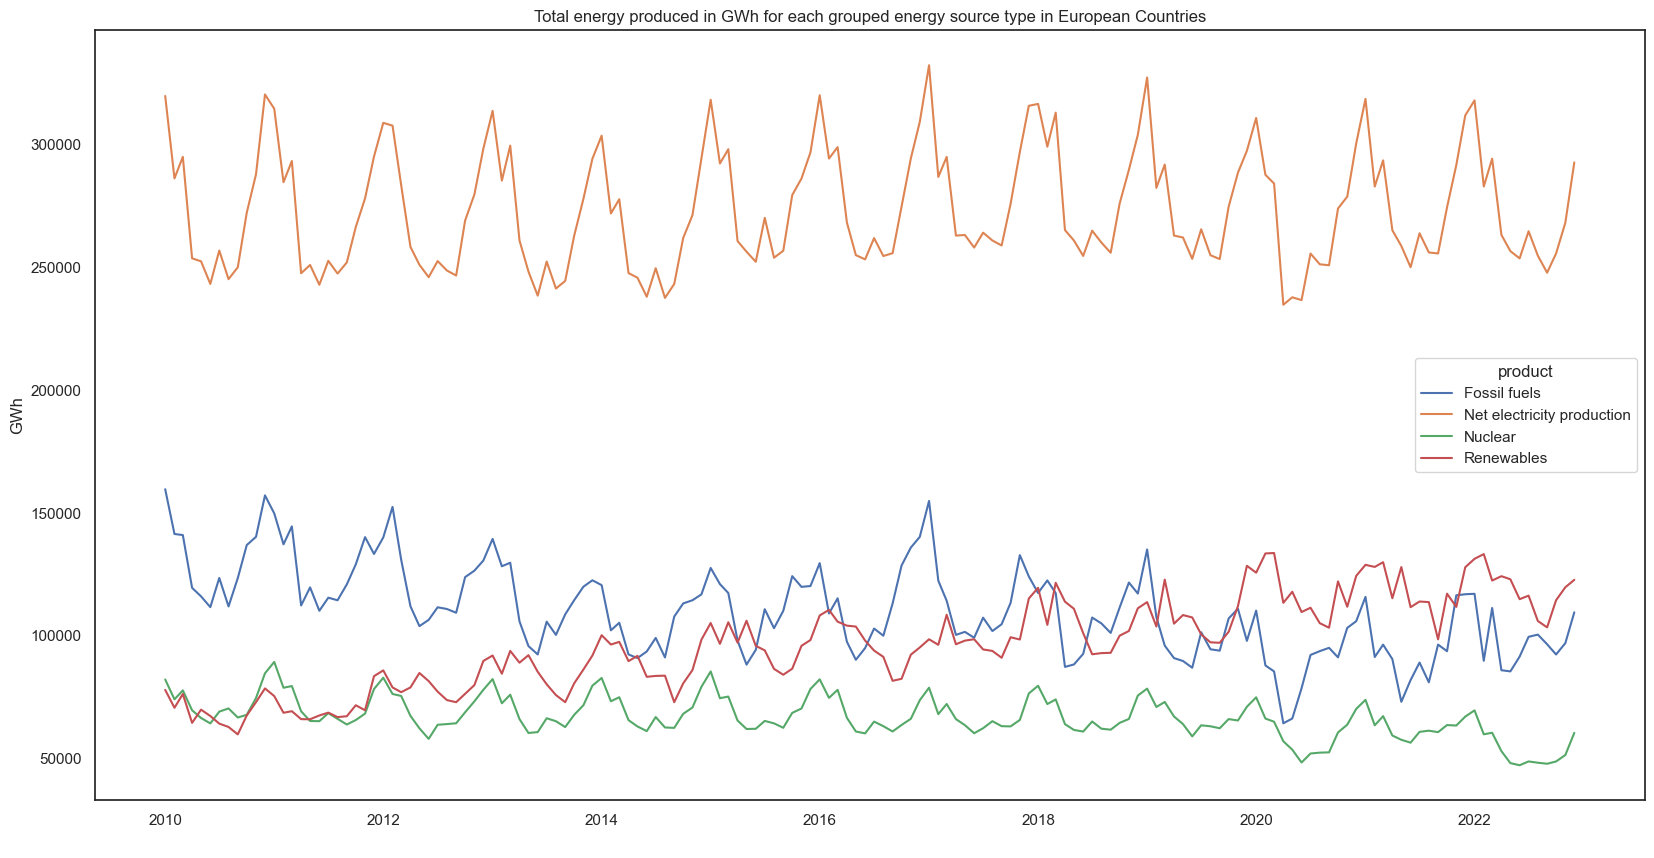

In [173]:
# Plot of the current data: grouped energy sources
data_fig = df[df['product'].isin(chosen_products_cat)]
sns.set_style(style='white') 
sns.lineplot(data=data_fig, 
                  x='time',
                  y='value', 
                  hue='product').set_title("Total energy produced in GWh for each grouped energy source type in European Countries")
plt.xlabel(" ")
plt.ylabel("GWh")
plt.show()

For each of the energy source type, we can observe **seasonality pattern** which is repeated annually. In addition, we can observe overall **trends**: the total energy produced seems to be either increasing (*Renewables*) or decreasing (*Fossil fuels* and *Nuclear*) for all energy source types. For *Renewables*, the magnitude of seasonality seems to change (increase) across time and therefore, **multiplicative model** will be used for this energy source type in the futher analyses. For other types, the change in seasonality does not seem to be as large and therefore, **additive model** will be used for other categories.


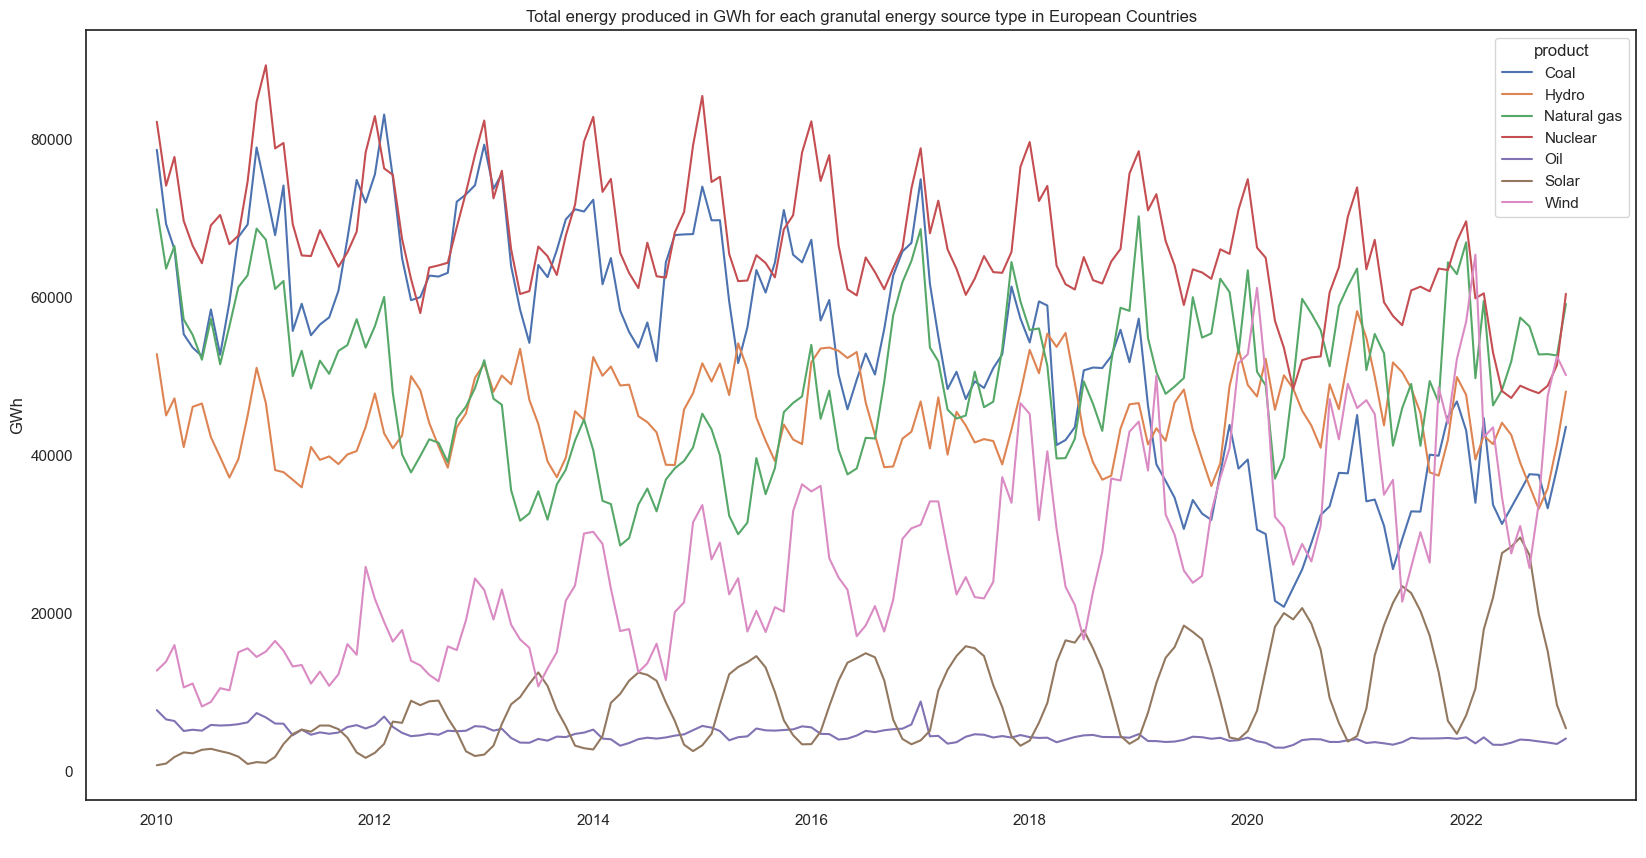

In [174]:
# Plot of the current data
data_fig = df[df['product'].isin(chosen_products_gran)]
sns.set_style(style='white') 
sns.lineplot(data=data_fig, 
                  x='time',
                  y='value', 
                  hue='product').set_title("Total energy produced in GWh for each granutal energy source type in European Countries")
sns.set(rc={'figure.figsize':(20, 10)})
plt.xlabel(" ")
plt.ylabel("GWh")
plt.show()

For the granular energy sources, we can also observe seasonality. However, for some energy sources, the magnitude of seasonality across time stays relatively stable (e.g. *Hydro*) whereas for others it changes (e.g. *Wind*). For the former, additive model will be used and for the latter the multiplicative model will be used. In addition, most energy sources show a trend of either increasing or decreasing. 

## 2.1 STL Decomposition

Next **STL (Seasonal and Trend) decomposition** with LOESS is done for each energy source separately to examine the seasonality and trends in more detail. 

In [175]:
def stl(product_name: str, model: str, data: pd.DataFrame) -> statsmodels.tsa.seasonal.DecomposeResult:
    """Function to perform Seasonal and Trend decomposition."""
    data_ff = data[data['product'] == product_name]
    series_ff = data_ff['value']
    series_ff.index = data_ff['time']  # Setting time variable as index
    stl_ff = seasonal_decompose(series_ff, model=model) # STL

    return stl_ff
    

In [176]:
def series_format(product: str, data: pd.DataFrame) -> pd.Series:
    """Returns Pandas Series object ('time' as an index) of the data for the chosen energy source"""
    data = data[data['product'] == product]
    data = data.groupby(['time'])['value'].sum().reset_index()
    
    series_data = data['value']
    series_data.index = data['time']
    
    # Analyses the observaton intervals within the time series and infers that the data is monthly
    series_data.index = pd.DatetimeIndex(series_data.index.values, freq=series_data.index.inferred_freq)

    return series_data

### 2.1.1 Overall Electricity Production

First, let's examine the trend and seasonality for the overall electricity production in European countries.

<class 'statsmodels.tsa.seasonal.DecomposeResult'>


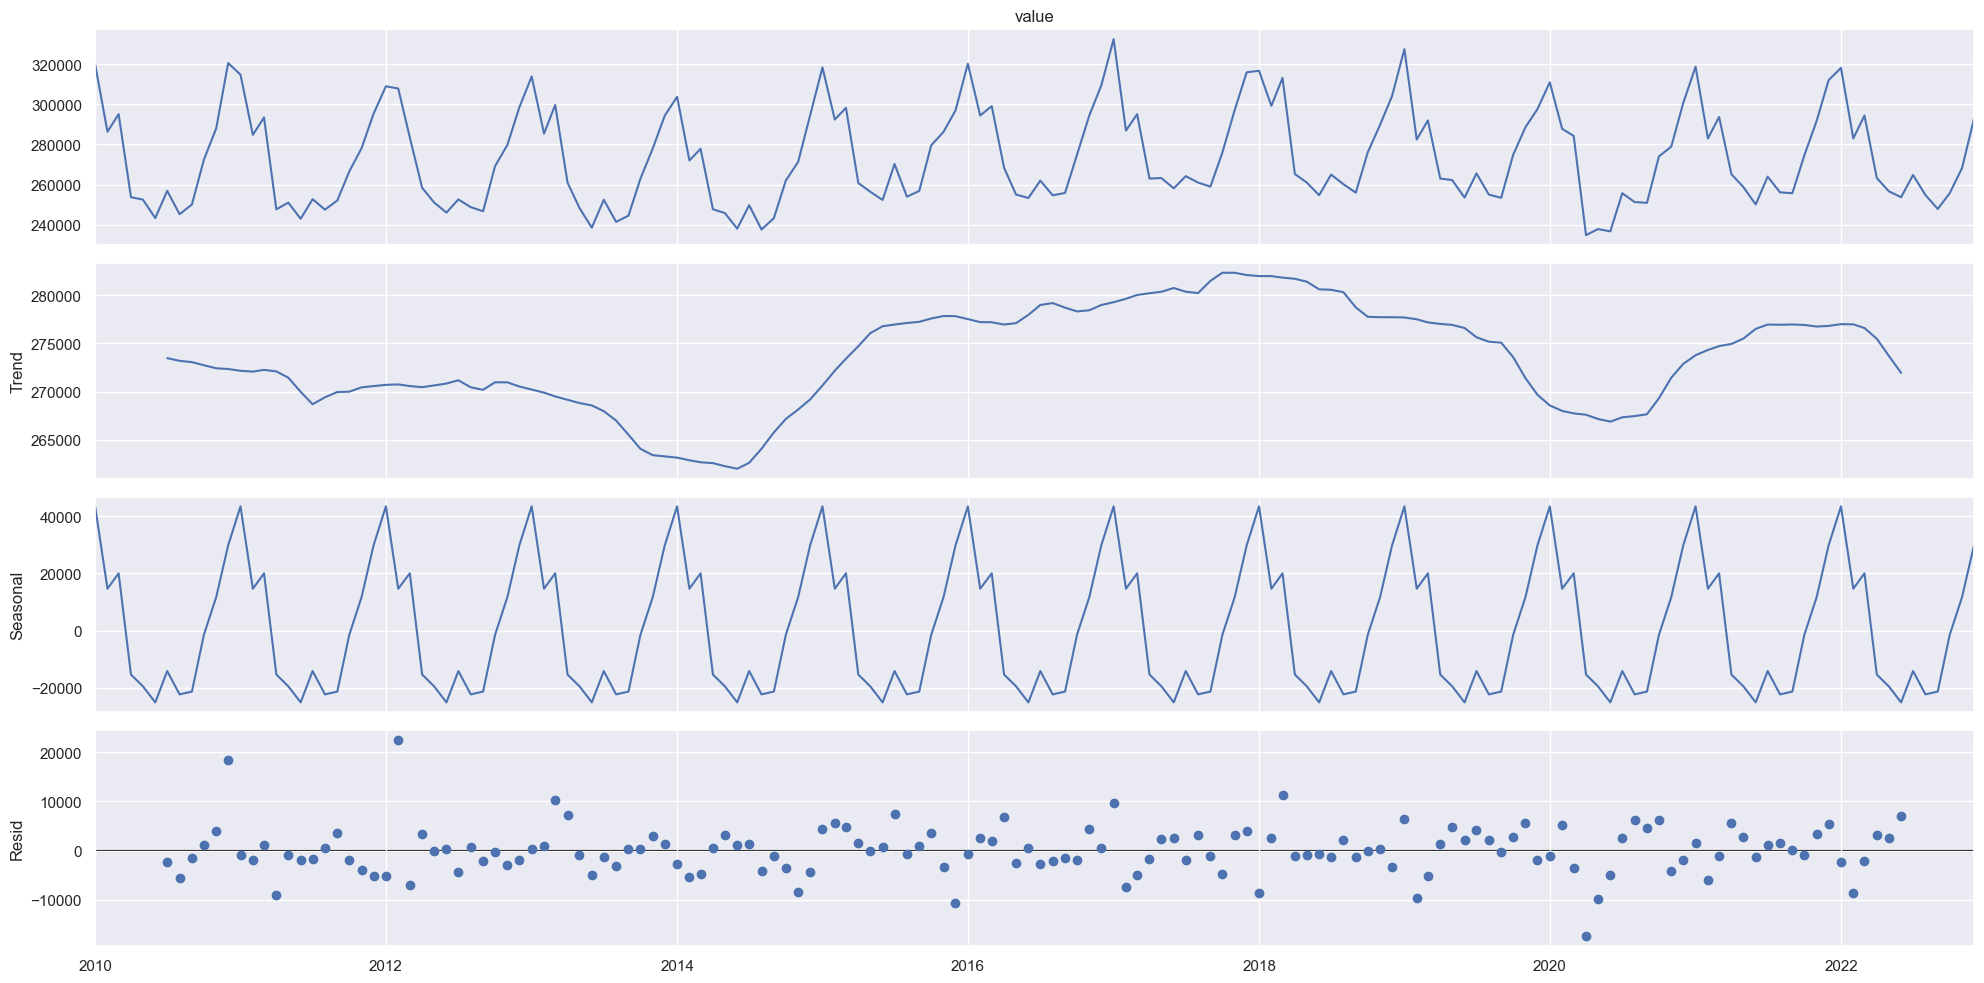

In [177]:
stl_overall = stl('Net electricity production', 'additive', df)
print(type(stl_overall))
stl_overall.plot()
plt.show()

We can see from the plots that overall electricity production has a decreasing trend until 2014 after which the data shows a positive trend until 2018. After 2018, the overall electricity production has decreased and increased once more. The data shows seasonality with 12 frequency and there does seem to be more variability in the overall electricty production between years 2010-2013 and in 2020.

### 2.1.2 Fossil Fuels

Next, we will examine the trend and seasonality for the energy source *Fossil fuels*. 

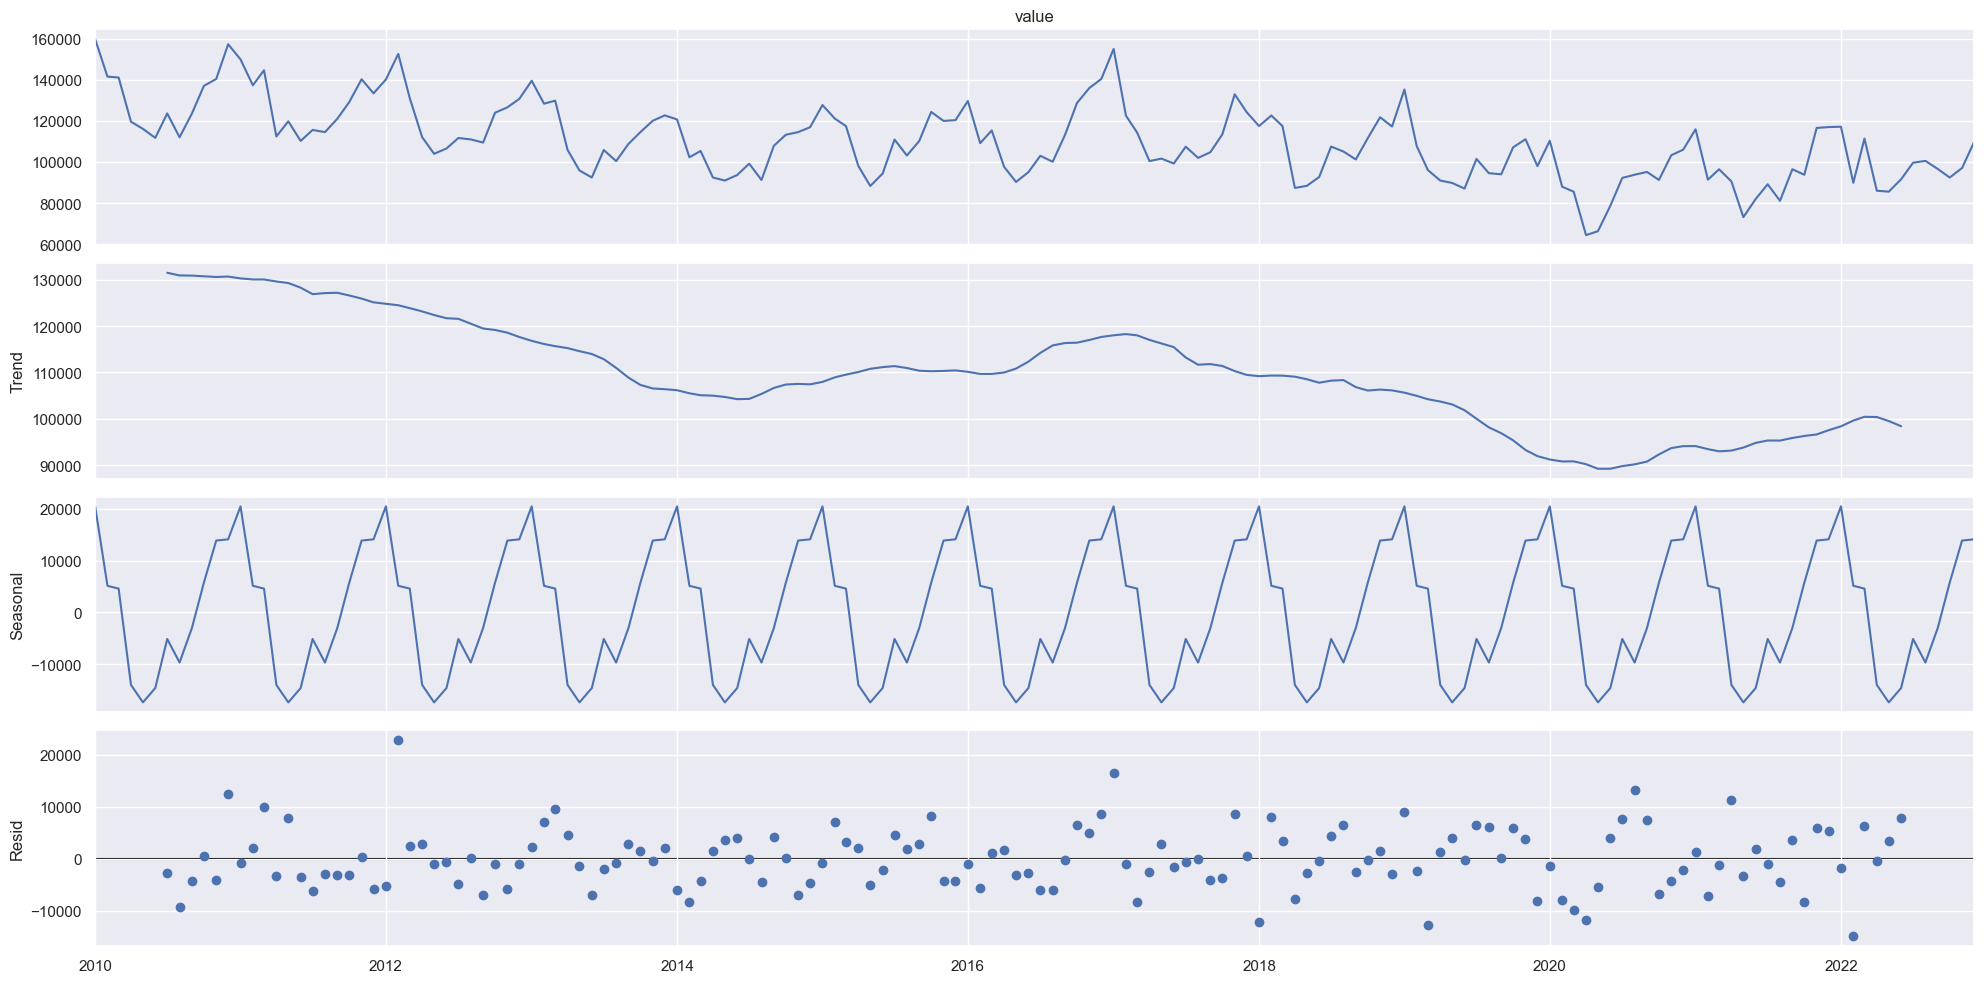

In [178]:
stl_ff = stl('Fossil fuels', 'additive', df)
stl_ff.plot()
plt.show()

From the plot, we can observe negative, decreasing overall trend. In addition, the data shows a repeating seasonal pattern with frequency of 12 months. The residuals also demonstrate that there seems to be some noise in the data. 

Next, in order to better understands the results for *Fossil fuel*, we will futher analyse the trend and seasonality for the following energy sources that compose fossil fuel: *Coal*, *Natural gas* and *Oil*. 

#### 2.1.2.1 Coal

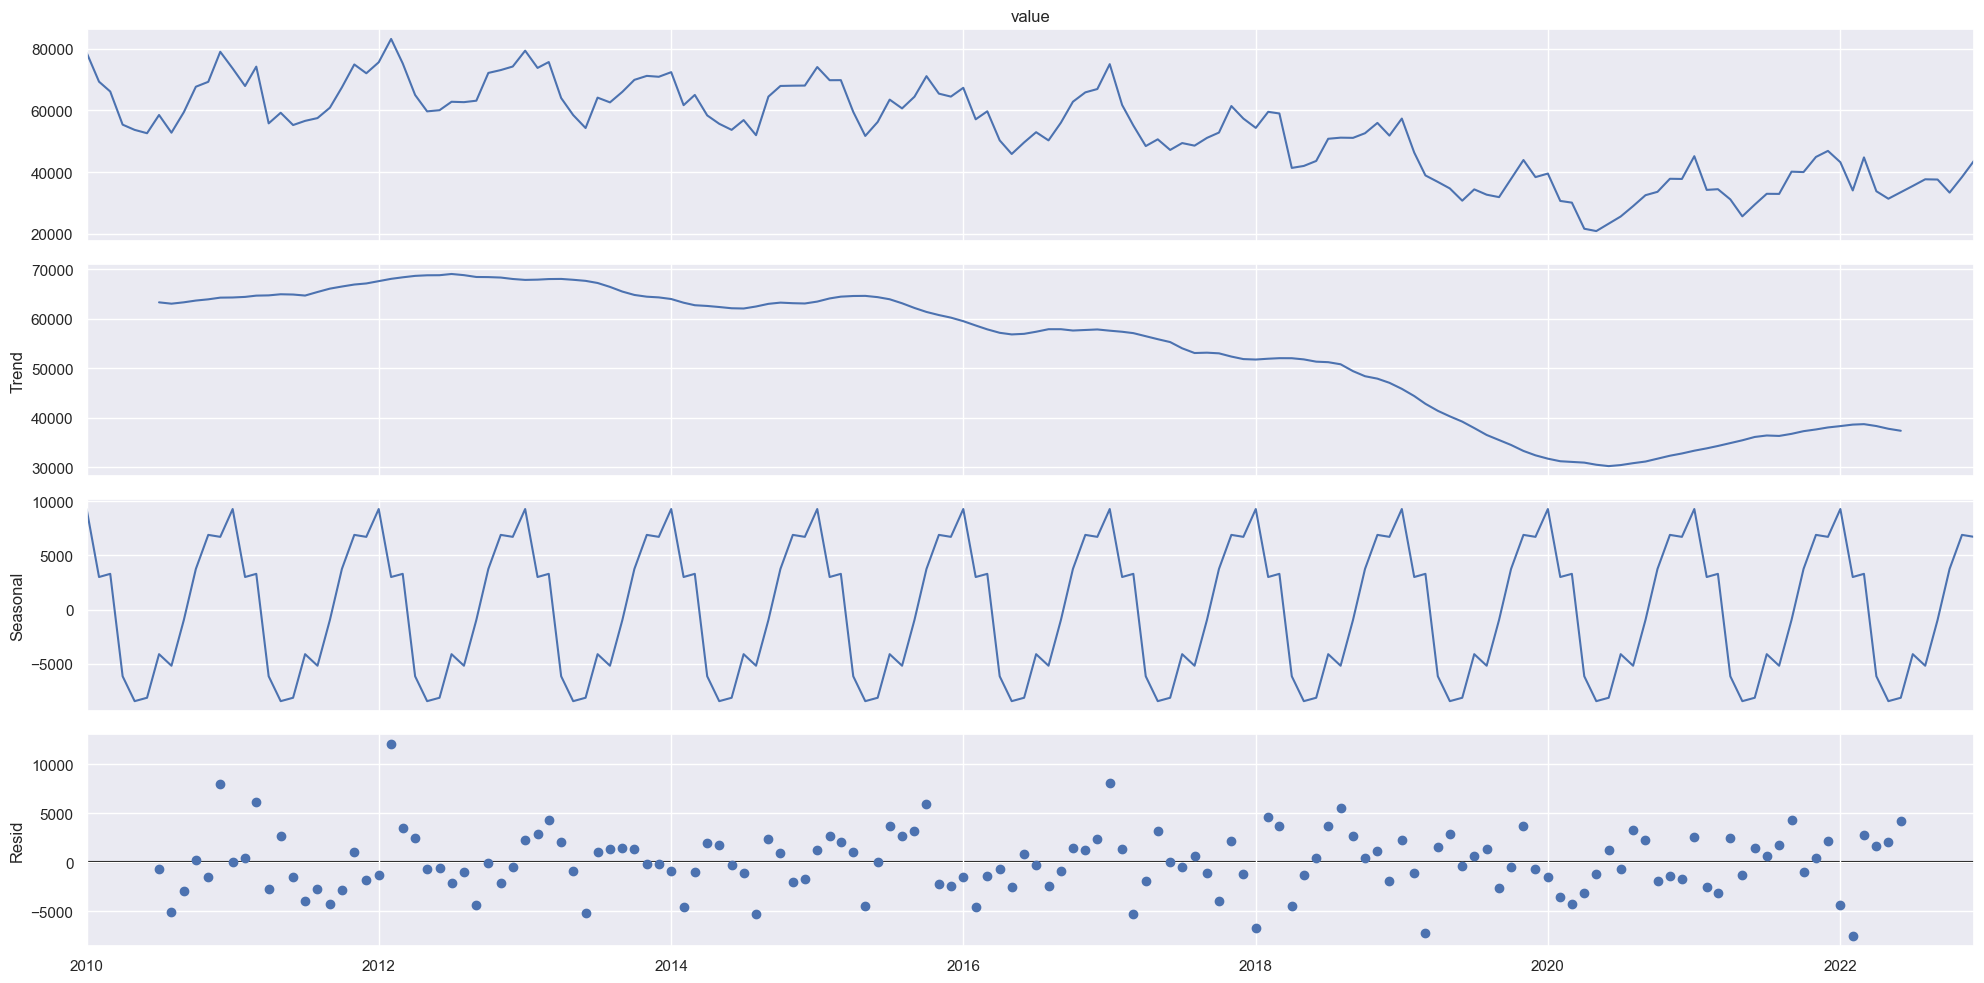

In [179]:
stl_coal = stl('Coal', 'additive', df)
stl_coal.plot()
plt.show()

Similar to *Fossil fuels*, the overall trend for *Coal* is decreasing and the seasonality patterns has frequency of 12. The data also shows almost similar amount of noise as *Fossil fuel*. 

#### 2.1.2.2 Natural Gas

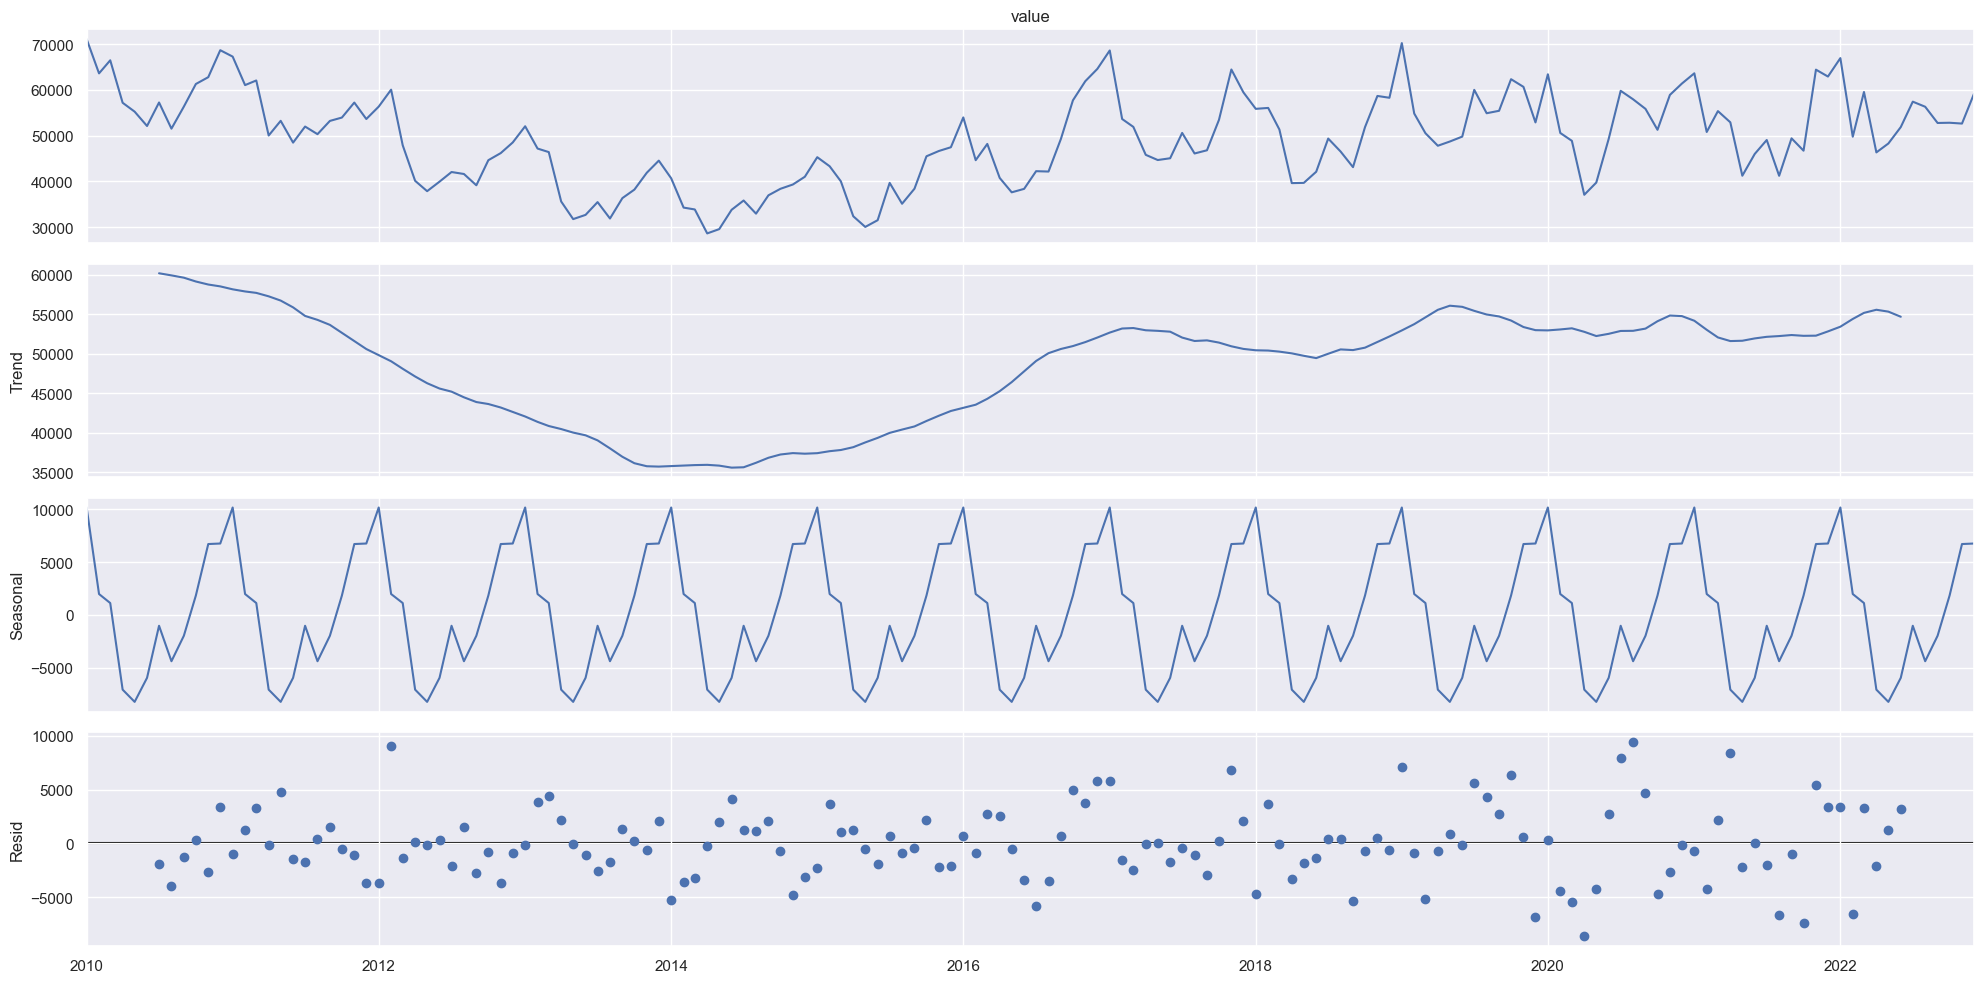

In [180]:
stl_naturalgas = stl('Natural gas', 'additive', df)
stl_naturalgas.plot()
plt.show()

In contrast to *Fossil fuel*, the trend for *Natural gas* seems to be first negative until 2014 in which the trend becomes positive. In addition, there seems to be more variablity in the total GWh produced with natural gas in the later years, starting from 2019. Similar to *Fossil fuels*, the data shows a clearn seasonality patern with frequency of 12. 

#### 2.1.2.3 Oil

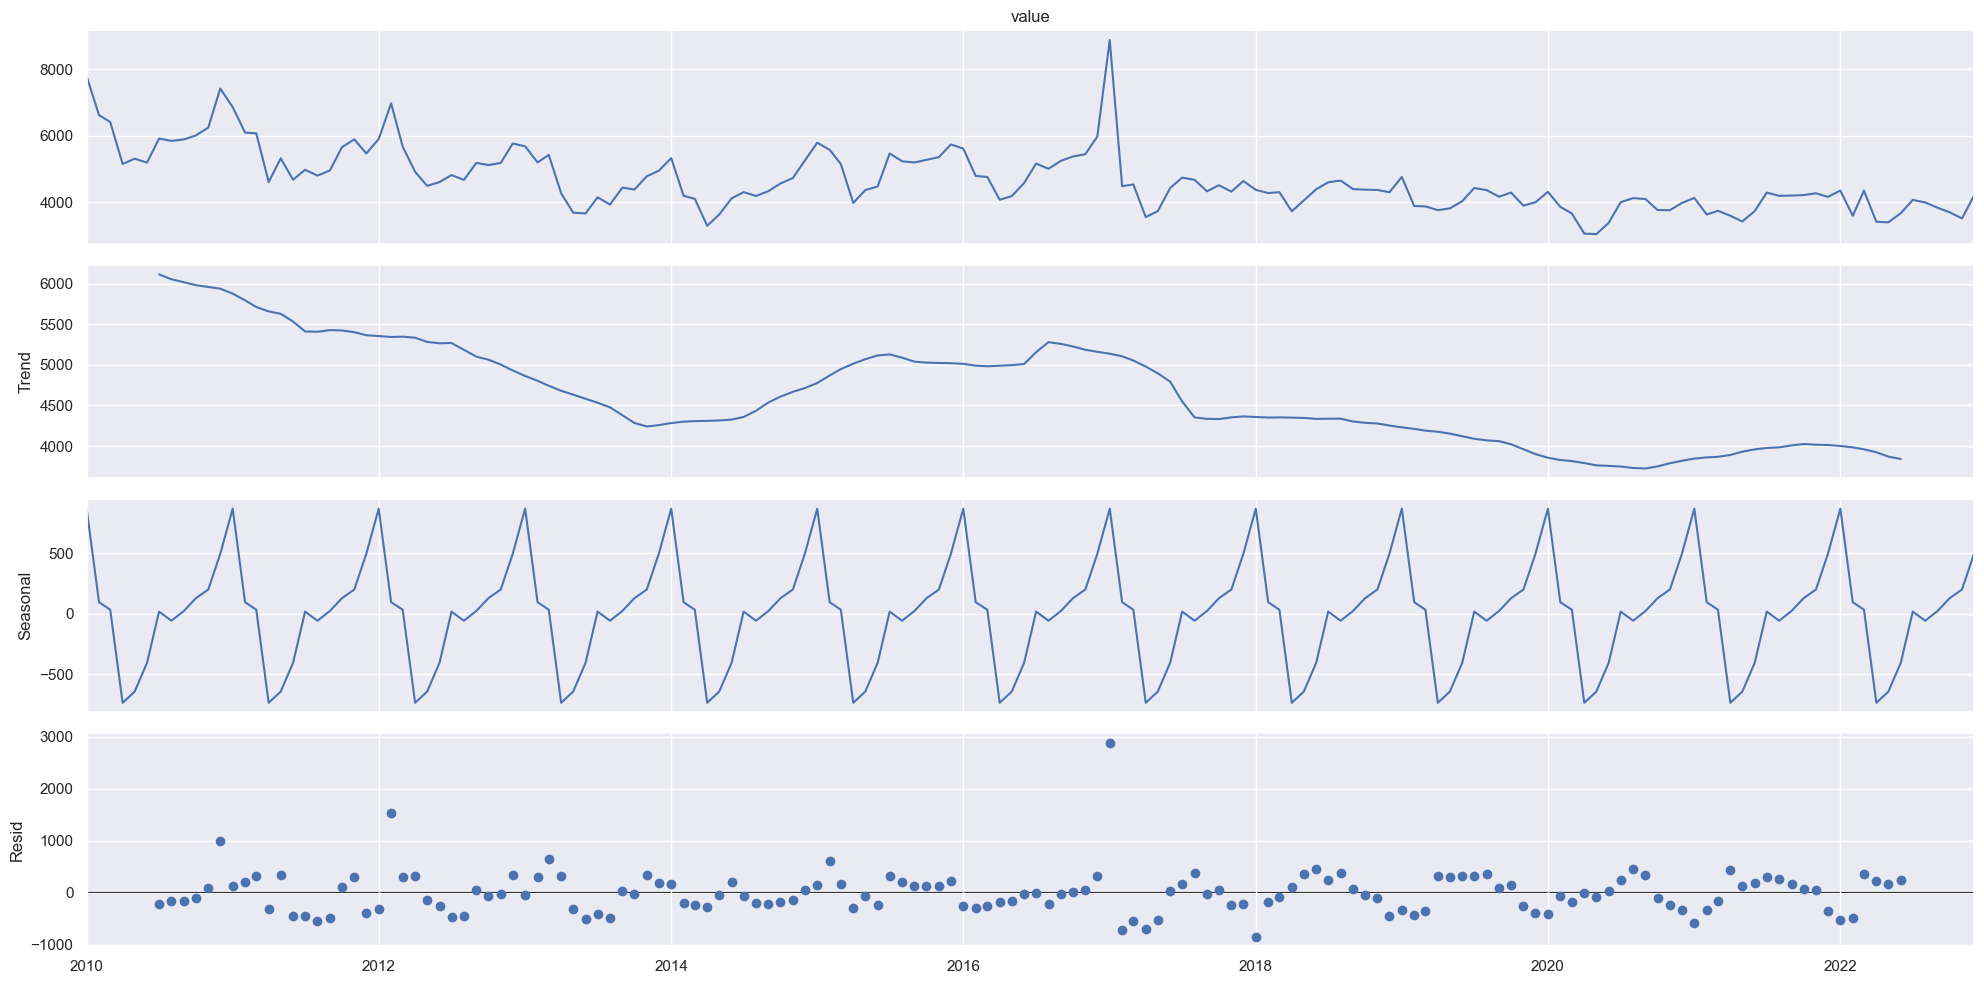

In [181]:
stl_oil = stl('Oil', 'additive', df)
stl_oil.plot()
plt.show()

The results for *Oil* are similar to *Fossil fuel*: the trend is overall decreasing and there is seasonality pattern with frequency of 12. However, there seems to be less variability in the total GWh generated by oil throughout the timeline compared to the other energy sources above. 

### 2.1.3 Renewables

Next, the seasonality and trend for *Renewables* is analysed by using STL.  

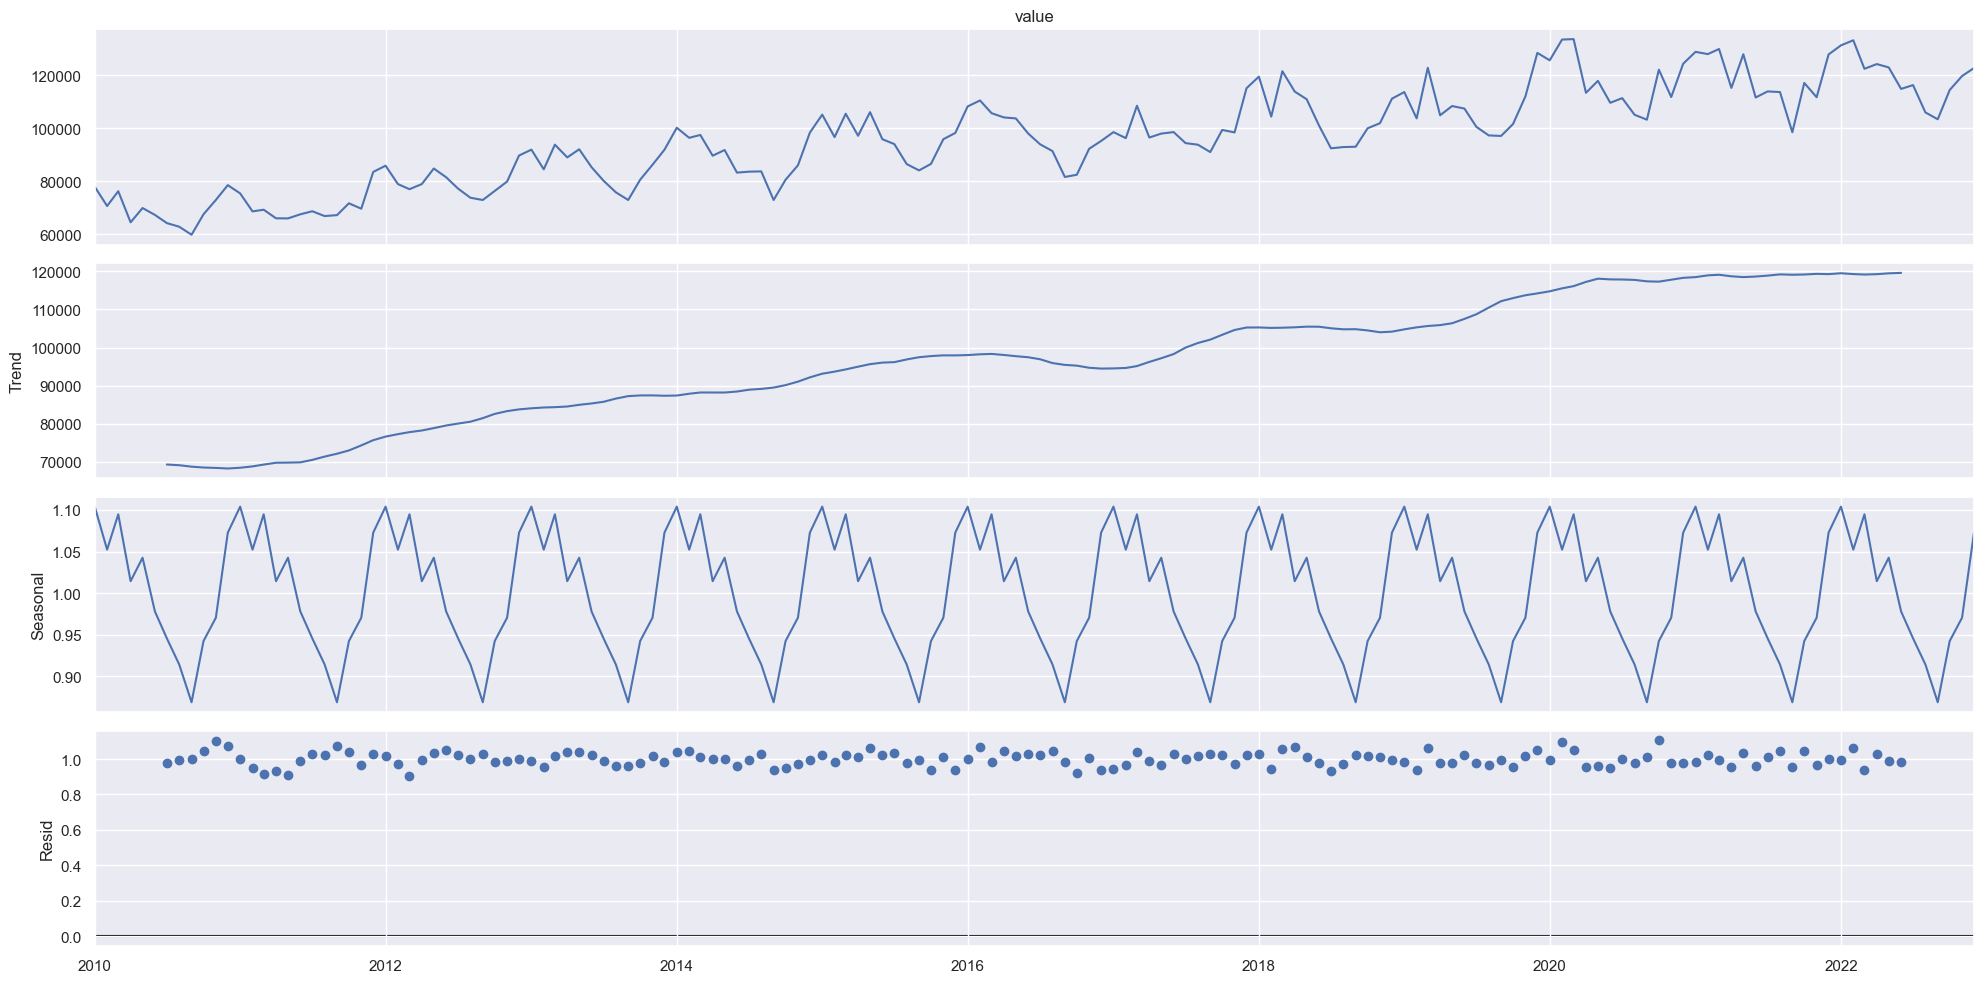

In [182]:
stl_r = stl("Renewables", 'multiplicative', df)
stl_r.plot()
plt.show()

For *Renewables* the overall trend is positive indicating that the total amount of energy generated with renewables has increased throughout the timeline. The data shows a clear seasonality pattern with frequency of 12.

Next, we will analyse three energy sources within renewables in more detail: *Wind*, *Hydro* and *Solar*.

#### 2.1.3.1 Wind

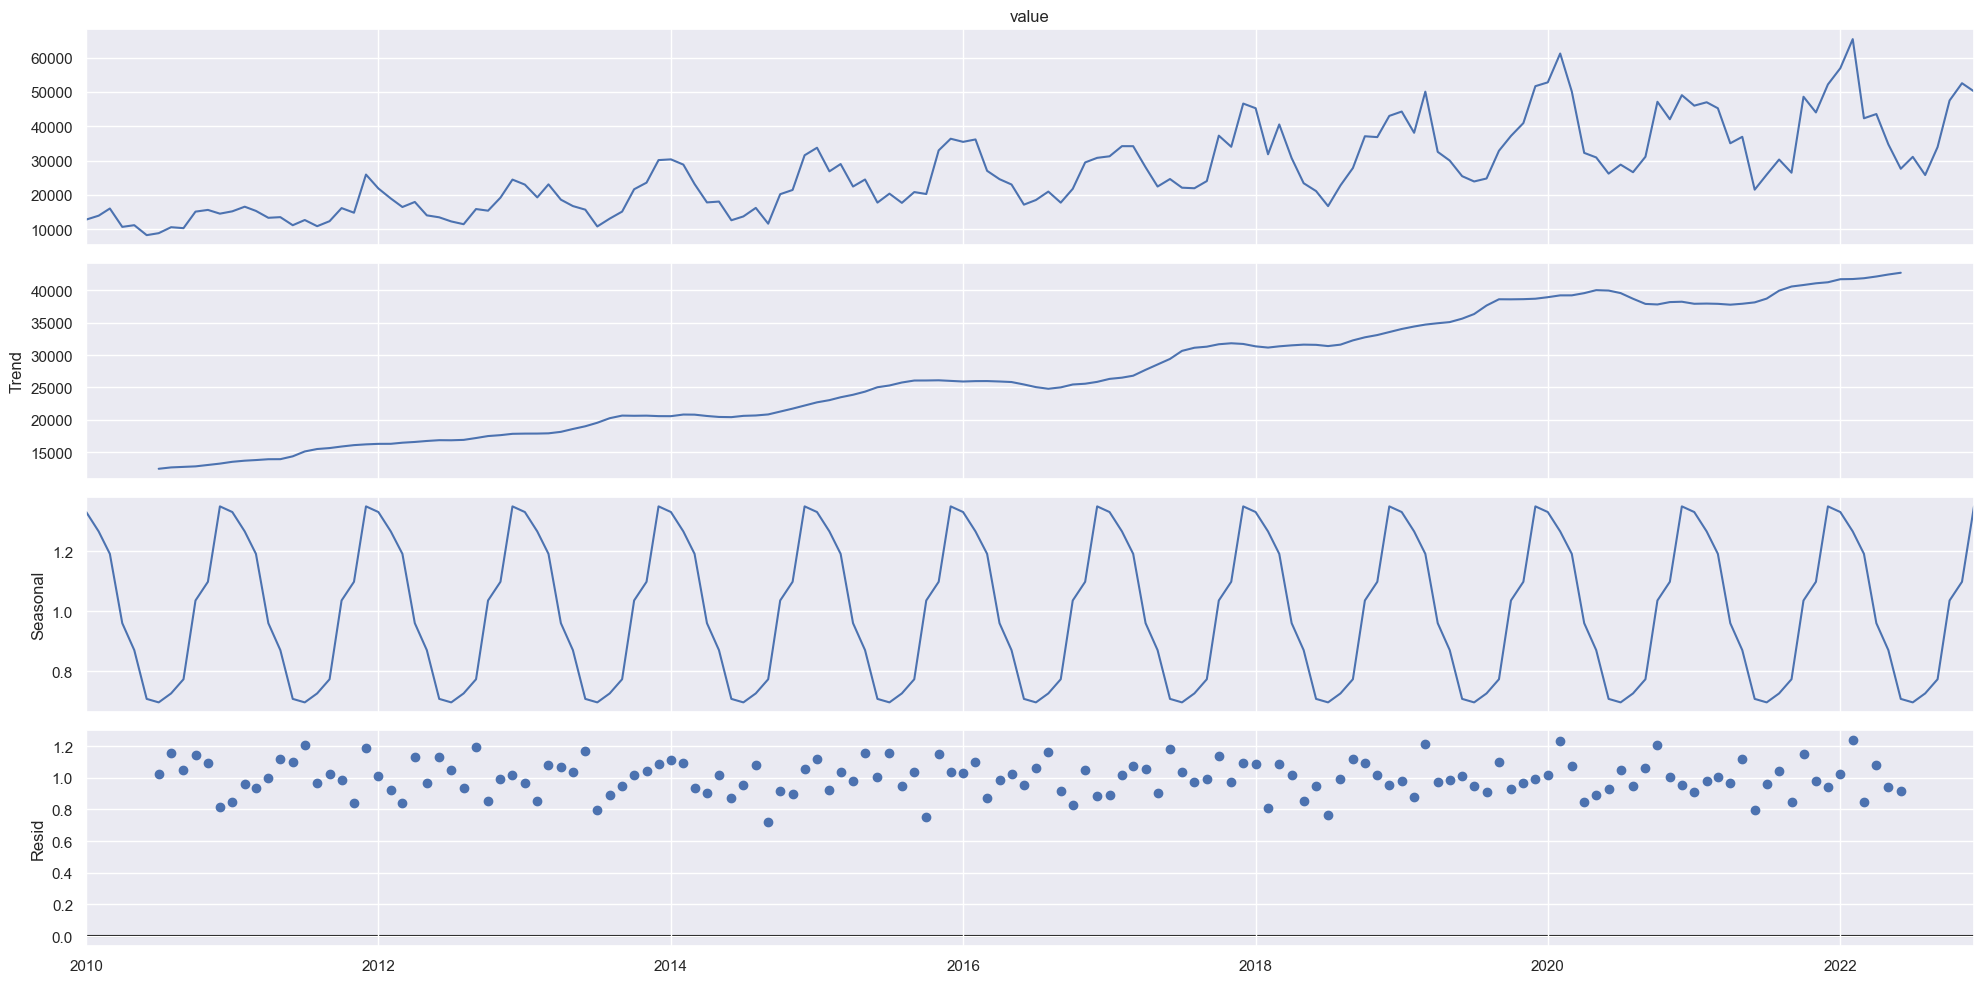

In [183]:
stl_wind = stl("Wind", 'multiplicative', df)
stl_wind.plot()
plt.show()

The results are similar for *Wind* as they were for *Renewables*: the overall trend is increasing, there is a seasonality pattern with frequency of 12.

#### 2.1.3.2 Hydro

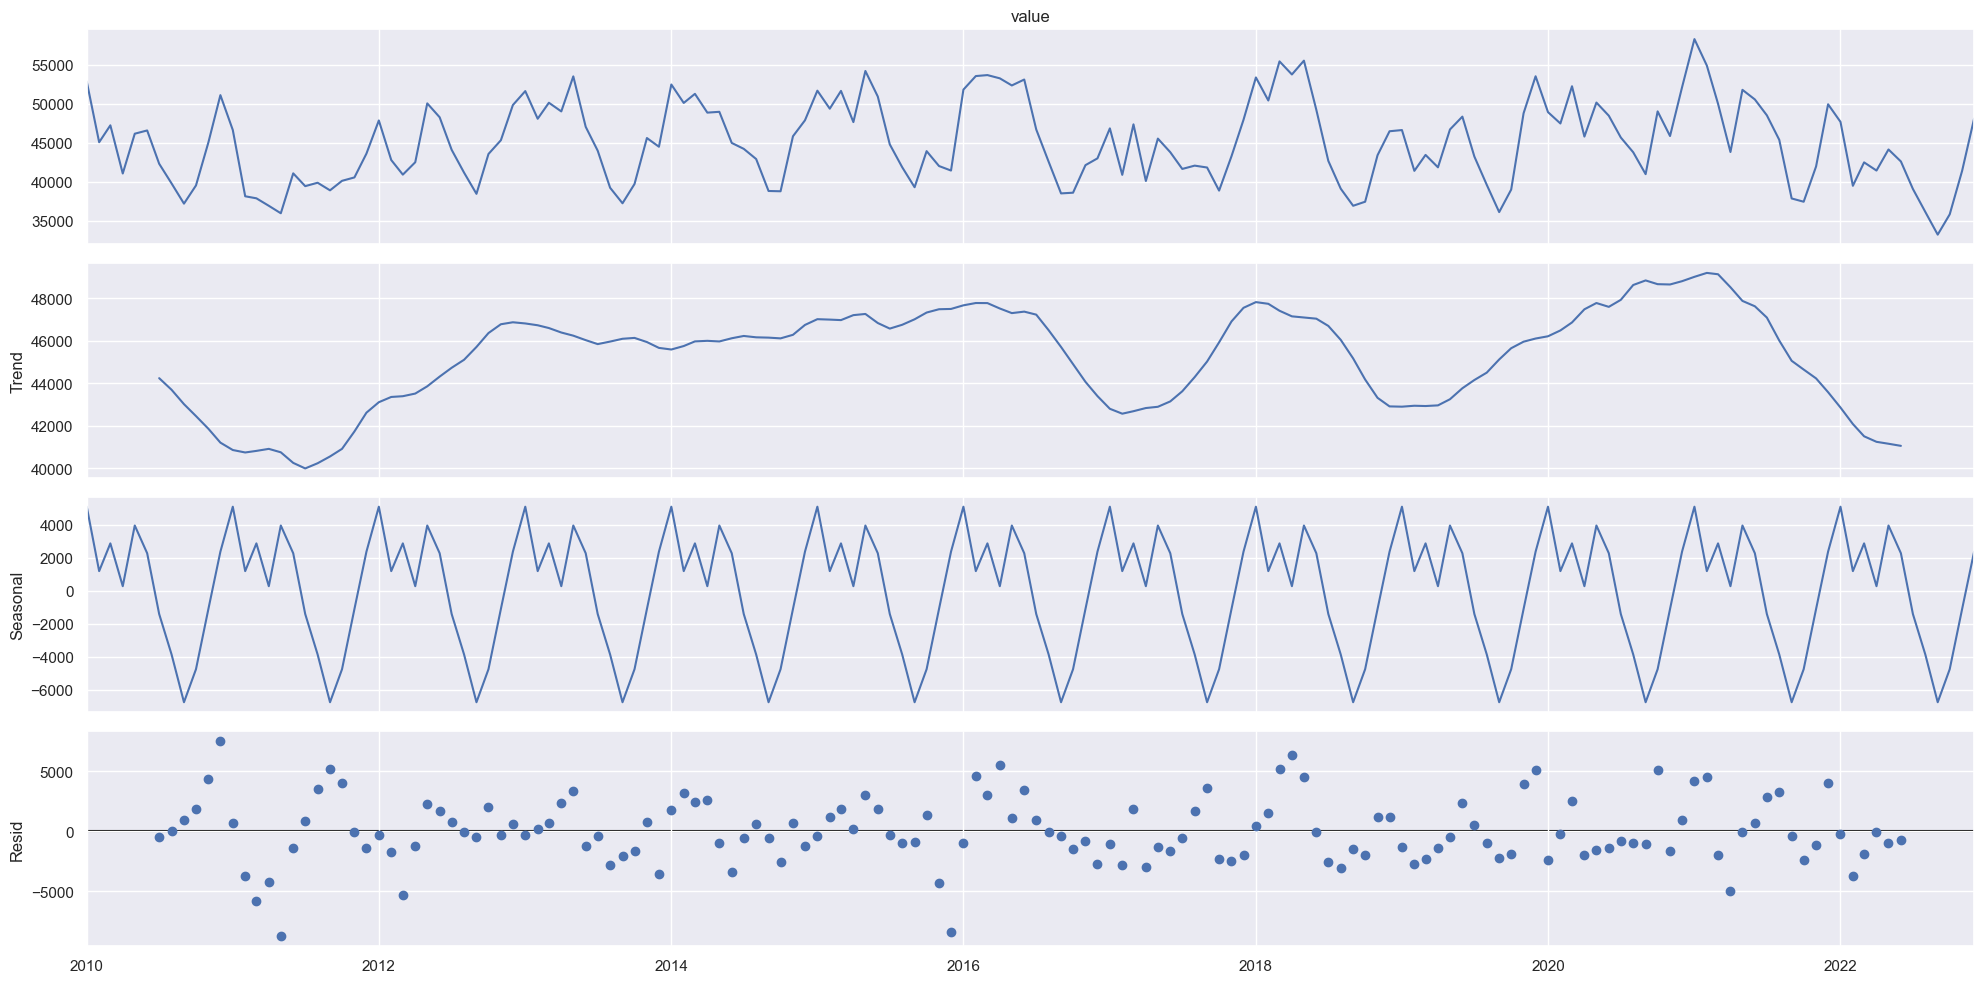

In [184]:
stl_hydro = stl("Hydro", 'additive', df)
stl_hydro.plot()
plt.show()

Compared to earlier renewable energy sources, the trend for *Hydro* shows larger variability: the trend was decreasing until 2012, after which the trend became quickly positive. Between 2013-2017 the trend was relatively stable and after 2017 the trend increased and decreased between one or two years periods. The amount of electricity generated with hydro shows a seasonality pattern with frequency 12 and there seems to be some noise present in the data throughout the timeline.

#### 2.1.3.3 Solar

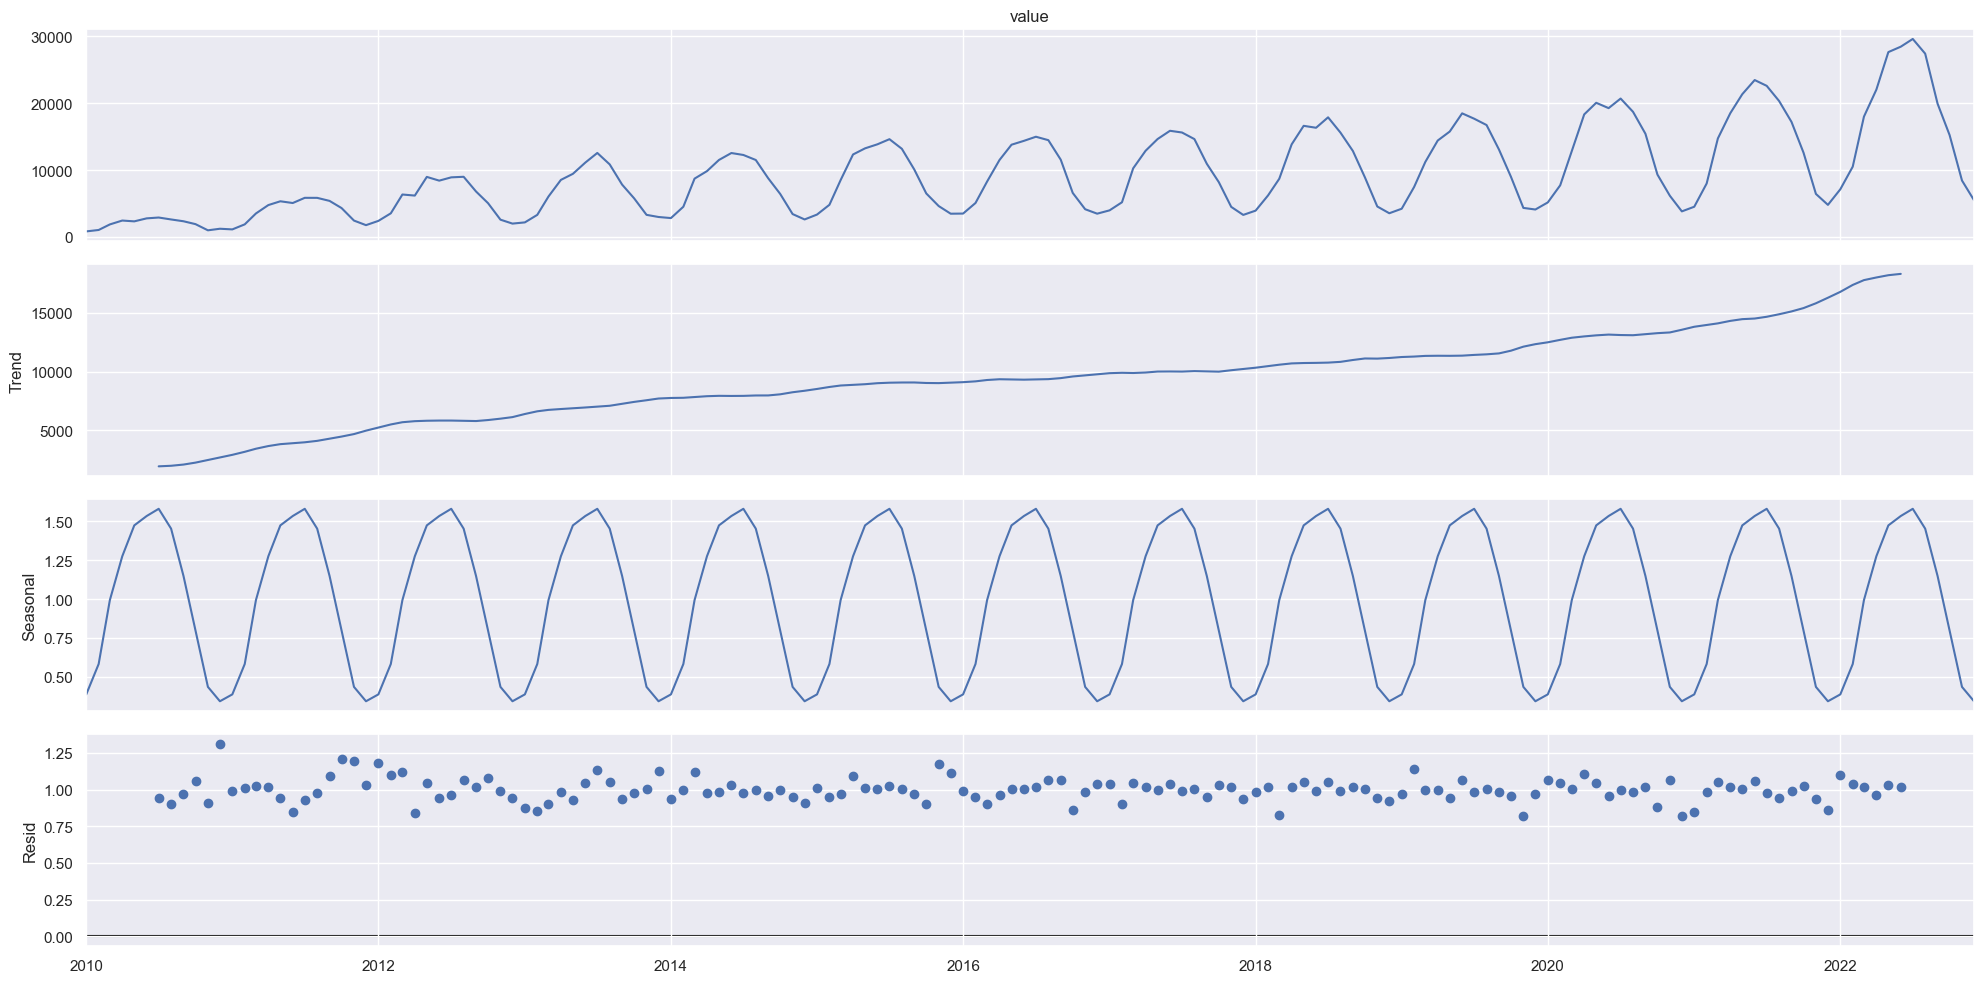

In [185]:
stl_solar = stl("Solar", 'multiplicative', df)
stl_solar.plot()
plt.show()

The trend for *Solar* is increasing throughout the timeline indicating that the amount of electricity generated with solar has increased since 2010. The data shows a seasonality pattern with frequency of 12.

### 2.1.4 Nuclear

Finally, the sesonality and trend for *Nuclear* is examined. 

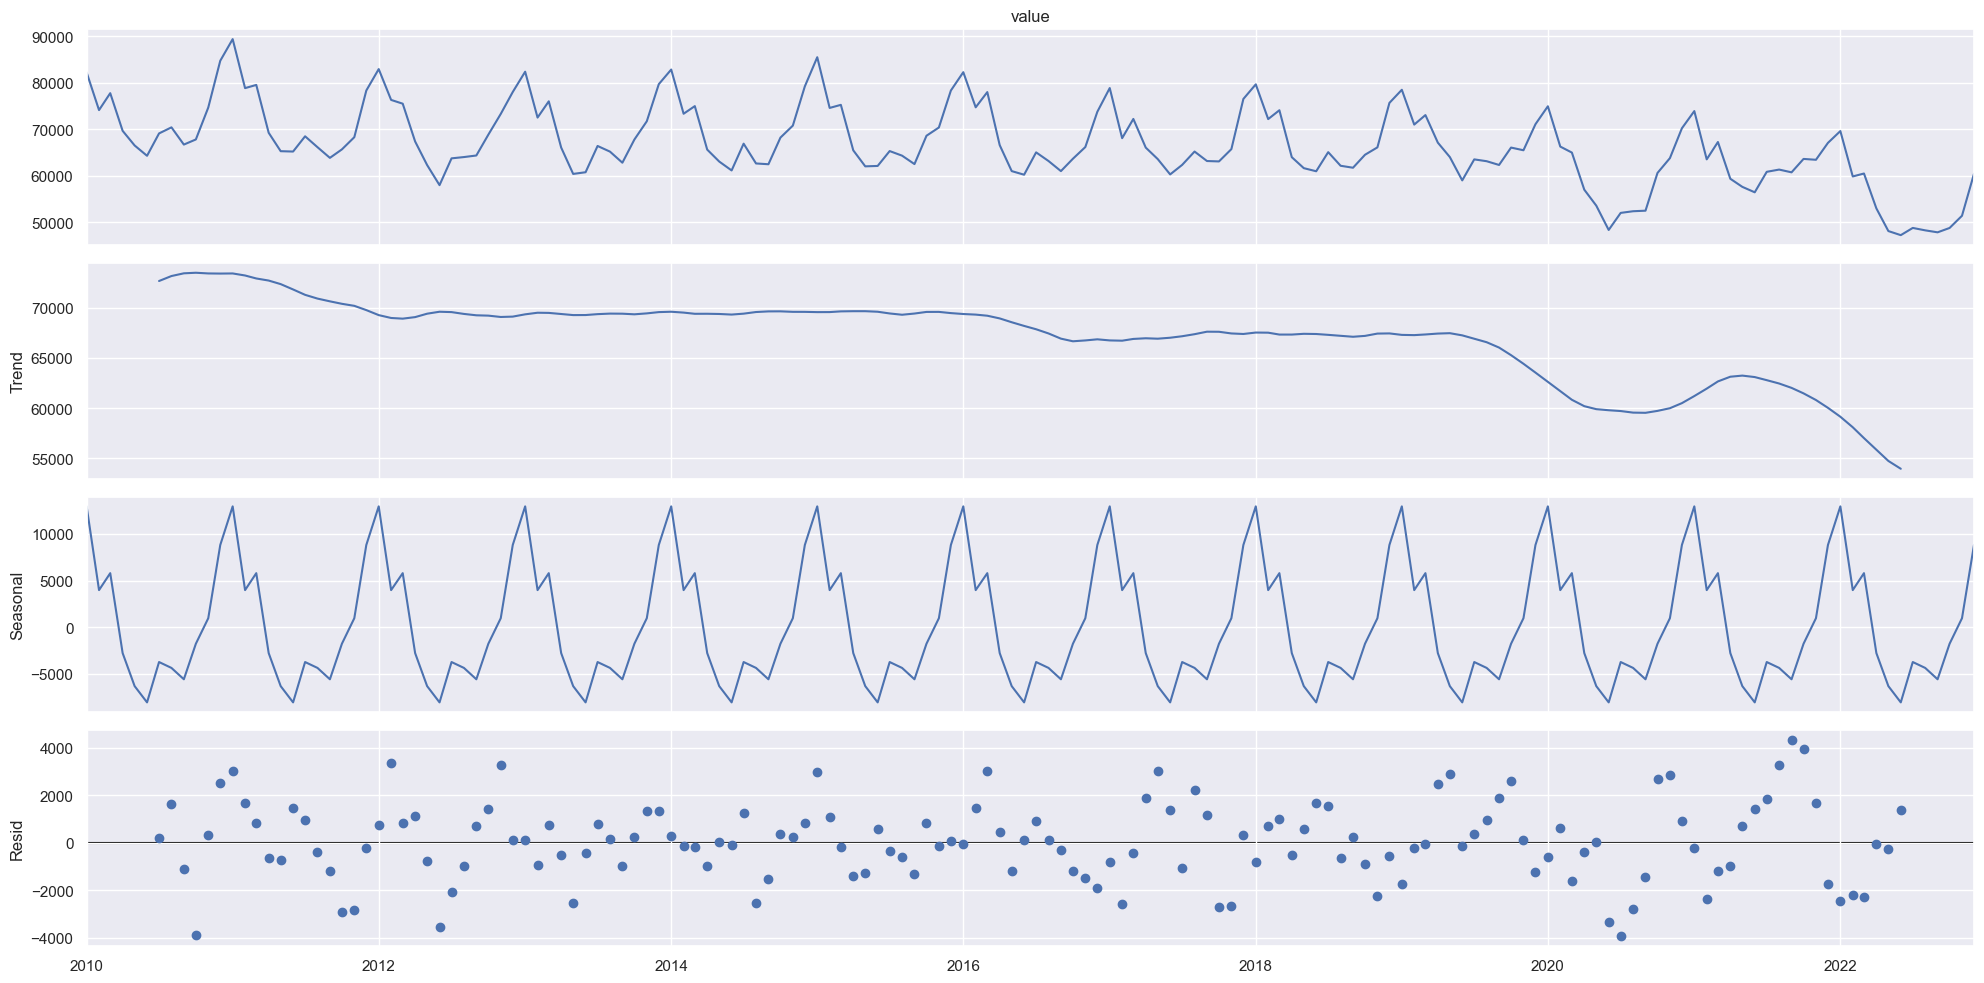

In [186]:
stl_nuclear = stl("Nuclear", 'additive', df)
stl_nuclear.plot()
plt.show()

The trend for *Nuclear* has stayed relatively stable, slightly decreasing, between years 2010 and 2019. After 2020, the trend shows a slight increase and then a large decrease indicating that the amount of electricity produced with nuclear has been overall decreasing and has had the largest decrease in 2022. As with the other energy sources, the data shows a clear seasonality pattern with frequncy of 12. There seems to be noise in the data throughout the timeline but slightly more in the earlier and later years.

## 2.1.5 Combined Trends for the Energy Sources

We can combine the original data and the trendlines in the same plot. This is done below separately for the total electricity production and for grouped and granular energy sources. 

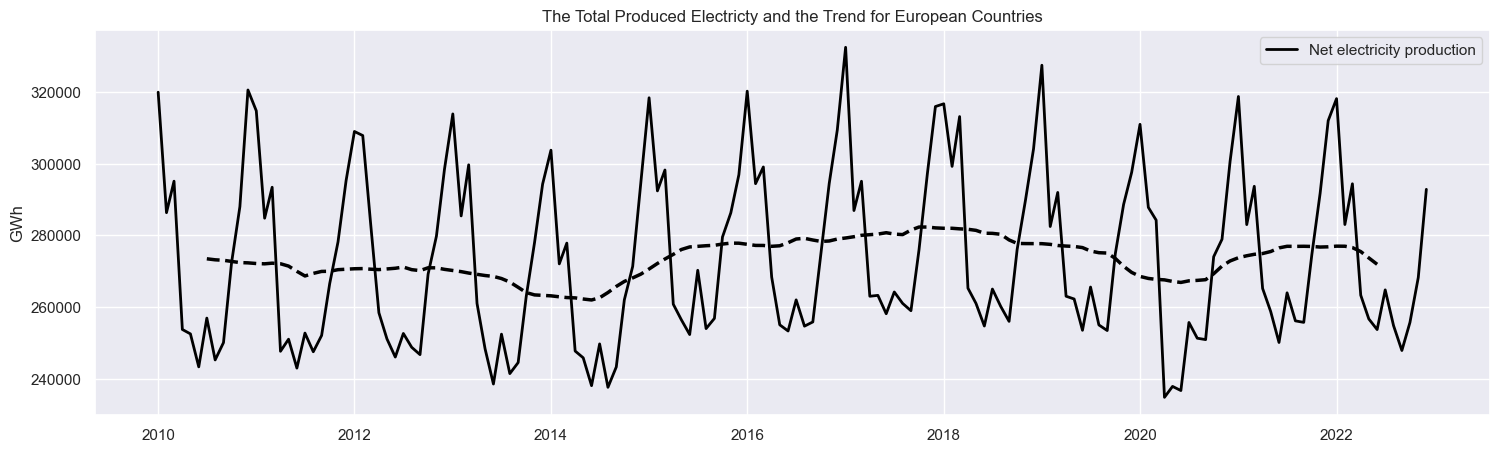

In [187]:
plt.figure(figsize=(18, 5))
plt.plot(stl_overall.observed, color='black', linewidth=2, label="Net electricity production")
plt.plot(stl_overall.trend, color='black', linewidth=2.5, linestyle="dashed")
plt.ylabel("GWh")
plt.title("The Total Produced Electricty and the Trend for European Countries")
plt.legend()
plt.show()

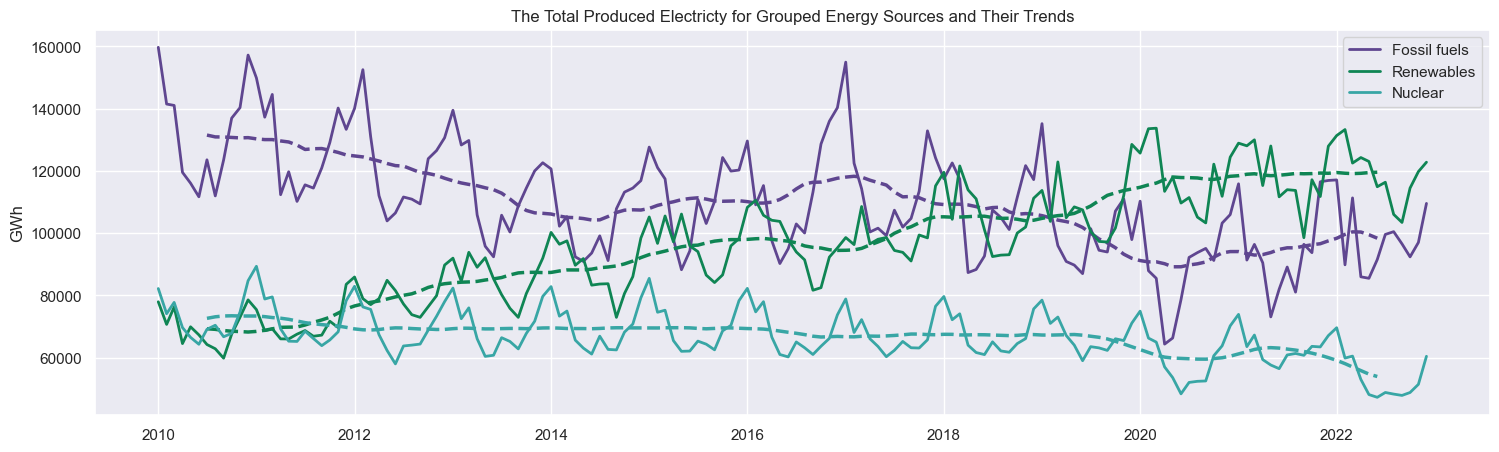

In [188]:
plt.figure(figsize=(18, 5))
plt.plot(stl_ff.observed, color='#5f4690', linewidth=2, label="Fossil fuels")
plt.plot(stl_ff.trend, color='#5f4690', linewidth=2.5, linestyle="dashed")
plt.plot(stl_r.observed, color='#0f8554', linewidth=2, label="Renewables")
plt.plot(stl_r.trend, color='#0f8554', linewidth=2.5, linestyle="dashed")
plt.plot(stl_nuclear.observed, color='#38a6a5', linewidth=2, label="Nuclear")
plt.plot(stl_nuclear.trend, color='#38a6a5', linewidth=2.5, linestyle="dashed")
plt.ylabel("GWh")
plt.title("The Total Produced Electricty for Grouped Energy Sources and Their Trends")
plt.legend()
plt.show()

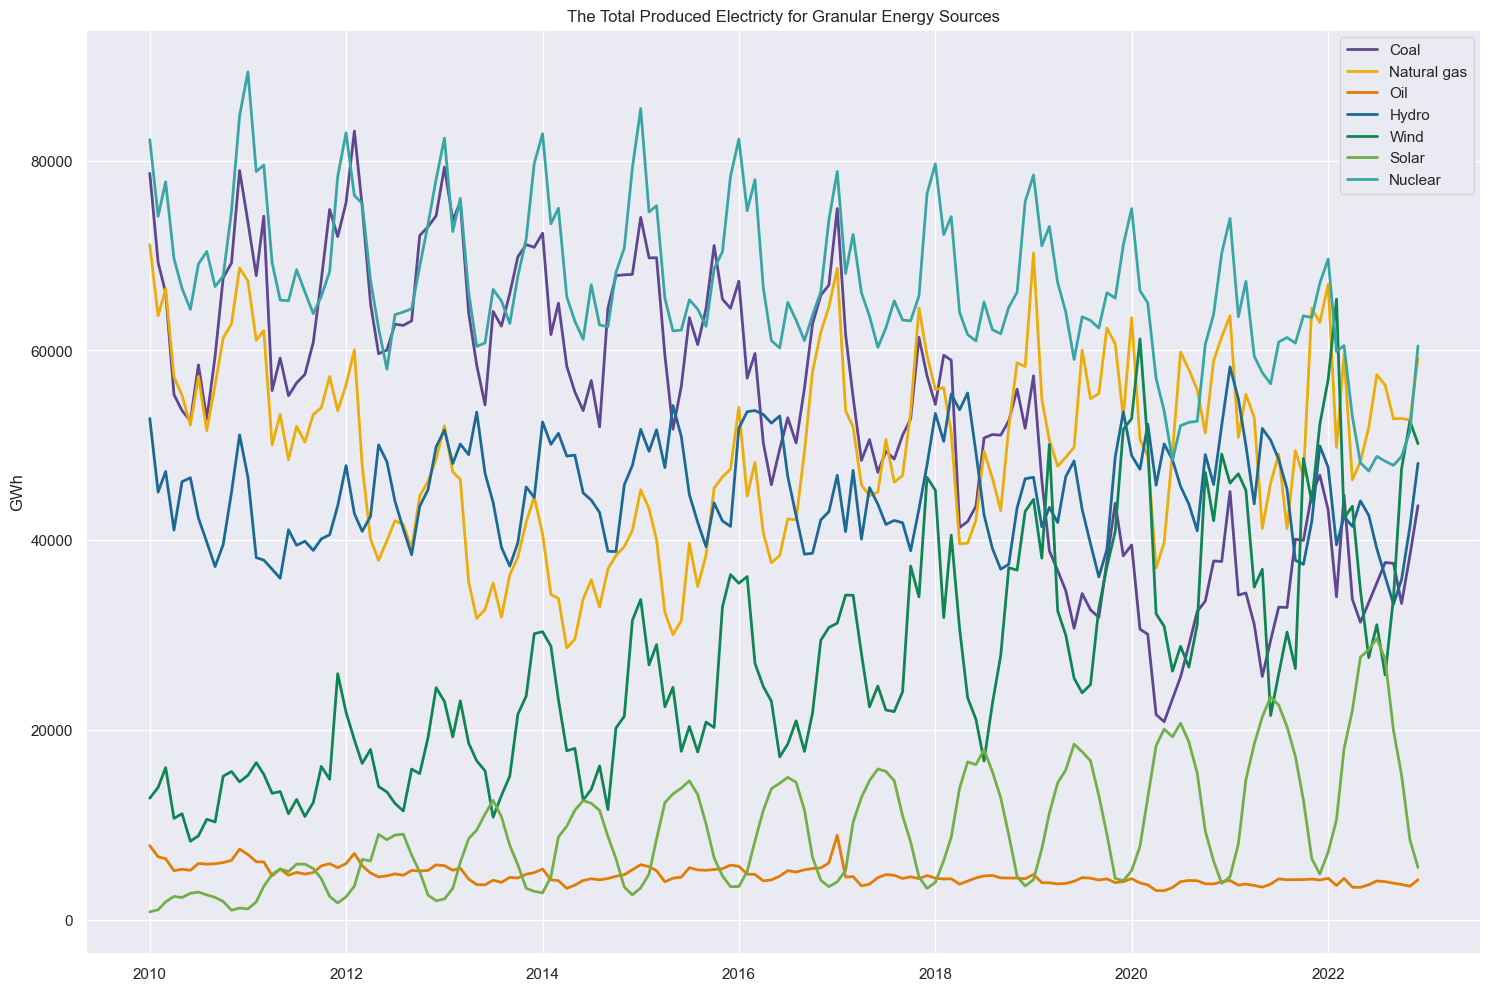

In [189]:
plt.figure(figsize=(18, 12))
plt.plot(stl_coal.observed, color='#5f4690', linewidth=2, label="Coal")
plt.plot(stl_naturalgas.observed, color='#edad08', linewidth=2, label="Natural gas")
plt.plot(stl_oil.observed, color='#e17c05', linewidth=2, label="Oil")
plt.plot(stl_hydro.observed, color='#1d6996', linewidth=2, label="Hydro")
plt.plot(stl_wind.observed, color='#0f8554', linewidth=2, label="Wind")
plt.plot(stl_solar.observed, color='#73af48', linewidth=2, label="Solar")
plt.plot(stl_nuclear.observed, color='#38a6a5', linewidth=2, label="Nuclear")
plt.ylabel("GWh")
plt.title("The Total Produced Electricty for Granular Energy Sources")
plt.legend()
plt.show()

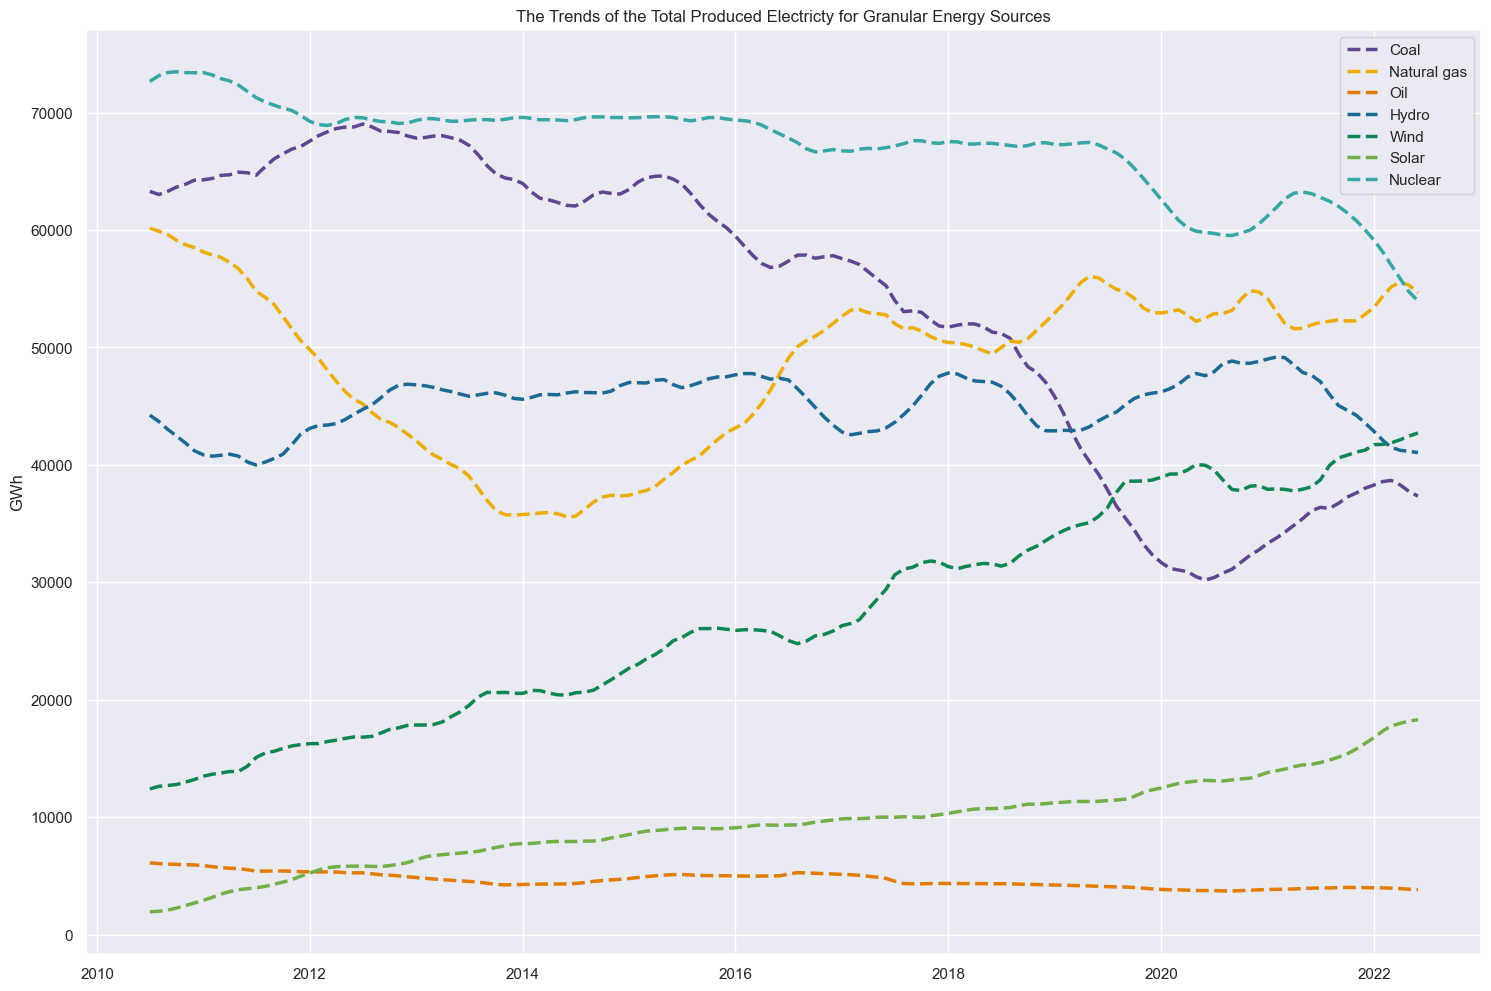

In [190]:
plt.figure(figsize=(18, 12))
plt.plot(stl_coal.trend, color='#5f4690', linewidth=2.5, linestyle="dashed", label="Coal")
plt.plot(stl_naturalgas.trend, color='#edad08', linewidth=2.5, linestyle="dashed", label="Natural gas")
plt.plot(stl_oil.trend, color='#e17c05', linewidth=2.5, linestyle="dashed", label="Oil")
plt.plot(stl_hydro.trend, color='#1d6996', linewidth=2.5, linestyle="dashed", label="Hydro")
plt.plot(stl_wind.trend, color='#0f8554', linewidth=2.5, linestyle="dashed", label="Wind")
plt.plot(stl_solar.trend, color='#73af48', linewidth=2.5, linestyle="dashed", label="Solar")
plt.plot(stl_nuclear.trend, color='#38a6a5', linewidth=2.5, linestyle="dashed", label="Nuclear")
plt.ylabel("GWh")
plt.title("The Trends of the Total Produced Electricty for Granular Energy Sources")
plt.legend()
plt.show()

## 2.2 Augmented Dickey Fuller (ADF) Tests

ADF Test will be used to determine if the data is stationary or not. As only the overall electricity production and grouped energy sources will be used in the  future analysis, only these ones are analysed. 

In [191]:
def adf(data: pd.Series) -> None:
    """Prints the results of the ADF Test for the given data"""
    adf_result = adfuller(data)
    print(f"Test Statistic: {round(adf_result[0], 3)}")
    print(f"p-value: {round(adf_result[1], 3)}")
    
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {round(value, 3)}")

    if adf_result[1] <= .05:
        print("Based on the p-value, we reject the hypothesis that the data has unit root. Therefore, the data is stationary.")
    else:
        print("Based on the p-value, we do not have enough evidence to reject the null hypothesis that the data has unit root. Therefore, the data is non-stationary.")

In [192]:
series_overall = series_format('Net electricity production', df) # Returns pd.Series() with the chosen energy source and time as index
print("ADF Test results for 'Net electricity production':")
adf(series_overall)

ADF Test results for 'Net electricity production':
Test Statistic: -2.104
p-value: 0.243
Critical values:
  1%: -3.478
  5%: -2.882
  10%: -2.578
Based on the p-value, we do not have enough evidence to reject the null hypothesis that the data has unit root. Therefore, the data is non-stationary.


In [193]:
series_ff = series_format('Fossil fuels', df)
print("ADF Test results for 'Fossil fuels':")
adf(series_ff)

ADF Test results for 'Fossil fuels':
Test Statistic: -1.897
p-value: 0.333
Critical values:
  1%: -3.478
  5%: -2.882
  10%: -2.578
Based on the p-value, we do not have enough evidence to reject the null hypothesis that the data has unit root. Therefore, the data is non-stationary.


In [194]:
series_nuclear = series_format('Nuclear', df)
print("ADF Test results for 'Nuclear':")
adf(series_nuclear)

ADF Test results for 'Nuclear':
Test Statistic: -0.529
p-value: 0.886
Critical values:
  1%: -3.477
  5%: -2.882
  10%: -2.578
Based on the p-value, we do not have enough evidence to reject the null hypothesis that the data has unit root. Therefore, the data is non-stationary.


In [195]:
series_r = series_format('Renewables', df)
print("ADF Test results for 'Renewables':")
adf(series_ff)

ADF Test results for 'Renewables':
Test Statistic: -1.897
p-value: 0.333
Critical values:
  1%: -3.478
  5%: -2.882
  10%: -2.578
Based on the p-value, we do not have enough evidence to reject the null hypothesis that the data has unit root. Therefore, the data is non-stationary.


As we can see from the results, the test statistic are larger than the critical values for all the variables and therefore, the *p*-value is larger than .05. This incidates that the data for overall electricity production and for grouped energy sources is **non-stationary**.

# 3. Data Preparation

Next the data needs to be prepared for the time-series forecasting by using the trainning and test sets, changing them data into a correct format and we need to test each energy source separately.

In [196]:
train_data = train_data[train_data['product'].isin(chosen_products_cat)]
test_data = test_data[test_data['product'].isin(chosen_products_cat)]

In [197]:
print(train_data.count())
print(type(train_data))
train_data.head(5)

country               14182
code_time             14182
time                  14182
year                  14182
month                 14182
month_name            14182
product               14182
value                 14182
display_order         14182
yearToDate            14182
previousYearToDate    12628
share                 14182
dtype: int64
<class 'pandas.core.frame.DataFrame'>


country code_time       time  year  month month_name  \
31  Austria   JAN2010 2010-01-01  2010      1    January   
39  Austria   JAN2010 2010-01-01  2010      1    January   
44  Austria   JAN2010 2010-01-01  2010      1    January   
48  Belgium   JAN2010 2010-01-01  2010      1    January   
56  Belgium   JAN2010 2010-01-01  2010      1    January   

                       product     value  display_order  yearToDate  \
31  Net electricity production  5901.466             14   67609.396   
39                  Renewables  3128.629             22   45809.266   
44                Fossil fuels  2772.836             27   21800.133   
48                     Nuclear  3788.629              6   45729.000   
56  Net electricity production  8340.712             14   91485.999   

    previousYearToDate     share  
31                 NaN  1.000000  
39                 NaN  0.530144  
44                 NaN  0.469855  
48                 NaN  0.454233  
56                 NaN  1.000000

In [198]:
print(test_data.count())
print(type(test_data))
test_data.head(5)

country               2868
code_time             2868
time                  2868
year                  2868
month                 2868
month_name            2868
product               2868
value                 2868
display_order         2868
yearToDate            2868
previousYearToDate    2868
share                 2868
dtype: int64
<class 'pandas.core.frame.DataFrame'>


country code_time       time  year  month month_name  \
151339  Austria   JAN2021 2021-01-01  2021      1    January   
151347  Austria   JAN2021 2021-01-01  2021      1    January   
151355  Austria   JAN2021 2021-01-01  2021      1    January   
151360  Austria   JAN2021 2021-01-01  2021      1    January   
151366  Belgium   JAN2021 2021-01-01  2021      1    January   

                           product        value  display_order    yearToDate  \
151339                     Nuclear     0.000000              6      0.000000   
151347  Net electricity production  5372.364589             14  67234.130288   
151355                  Renewables  3539.797065             22  53472.615010   
151360                Fossil fuels  1832.567525             27  13761.515277   
151366                     Nuclear  3873.053868              6  47891.716523   

        previousYearToDate     share  
151339            0.000000  0.000000  
151347         5632.027491  1.000000  
151355         3343.129417  0.658890  
151360         2288.898074  0.341110  
151366         3054.762182  0.451893

In [199]:
# Making pd.Series() object for forecasting and changing index to 'time' variable
train_series_overall = series_format('Net electricity production', train_data)
test_series_overall = series_format('Net electricity production', test_data)

train_series_ff = series_format('Fossil fuels', train_data)
test_series_ff = series_format('Fossil fuels', test_data)

train_series_r = series_format('Renewables', train_data)
test_series_r = series_format('Renewables', test_data)

train_series_nuclear = series_format('Nuclear', train_data)
test_series_nuclear = series_format('Nuclear', test_data)


# 4. Time-series forecasting algorithms

In [200]:
def model_performance_eval(final_model_fit: pd.Series, test_data: pd.Series) -> tuple:
    """Returns MSE, RMSE, MAE and AIC of given model"""
    
    model_predictions = final_model_fit.forecast(len(test_data))

    MSE = mean_squared_error(test_data, model_predictions)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(test_data, model_predictions)
    AIC = final_model_fit.aic

    return (MSE, RMSE, MAE, AIC)

## 4.1 Holt-Winter Exponential Smoothing (HWES)

The first time series algorithm which will be used to predict the total electricity generated for the grouped neergy sources is HWES. When examining the total produced electicity with all nergy sources, three diferent types of HW Exponential Smooting algoritms will be compared: simple, double and triple. The model that best fitst the data will be used for the rest of the grouped energy sources.

### 4.1.1 Net electricity production

First we will examine the Single HWES which is mainly used for univariate data and does not take into account trend or seasonality. Therefore, it is expected to perform the worsy from the three methods. Different smoothing levels, which defines how fast the influence of past observations decreases, are compared.

In [201]:
# Simple HW Exponential Smoothing model
HWES_model_overall = SimpleExpSmoothing(train_series_overall, initialization_method="estimated") # Simple HWE
HWES_model_overall_fit1 = HWES_model_overall.fit(smoothing_level=0.2)
HWES_model_overall_fit2 = HWES_model_overall.fit(smoothing_level=0.4)
HWES_model_overall_fit3 = HWES_model_overall.fit(smoothing_level=0.6)
HWES_model_overall_fit4 = HWES_model_overall.fit(smoothing_level=0.8)
HWES_model_overall_fit5 = HWES_model_overall.fit()


In [202]:
HWES_model_overall_pred1 = HWES_model_overall_fit1.predict(start=test_series_overall.index[0], end=test_series_overall.index[-1])
HWES_model_overall_pred2 = HWES_model_overall_fit2.predict(start=test_series_overall.index[0], end=test_series_overall.index[-1])
HWES_model_overall_pred3 = HWES_model_overall_fit3.predict(start=test_series_overall.index[0], end=test_series_overall.index[-1])
HWES_model_overall_pred4 = HWES_model_overall_fit4.predict(start=test_series_overall.index[0], end=test_series_overall.index[-1])
HWES_model_overall_pred5 = HWES_model_overall_fit5.predict(start=test_series_overall.index[0], end=test_series_overall.index[-1])

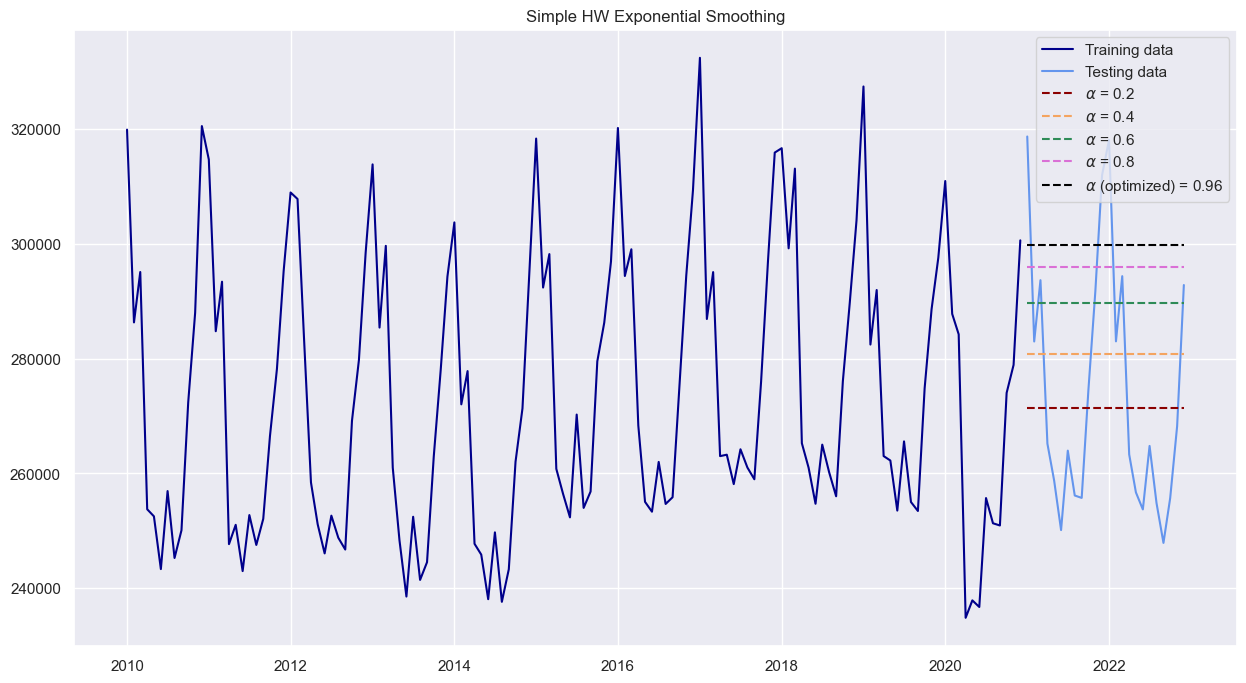

In [203]:
plt.figure(figsize=(15,8))
plt.plot(train_series_overall, color='darkblue', label="Training data")
plt.plot(test_series_overall, color='cornflowerblue', label="Testing data")
plt.plot(HWES_model_overall_pred1, color='darkred', label=r"$\alpha$ = 0.2", linestyle="dashed")
plt.plot(HWES_model_overall_pred2, color='sandybrown', label=r"$\alpha$ = 0.4", linestyle="dashed")
plt.plot(HWES_model_overall_pred3, color='seagreen', label=r"$\alpha$ = 0.6", linestyle="dashed")
plt.plot(HWES_model_overall_pred4, color='orchid', label=r"$\alpha$ = 0.8", linestyle="dashed")
plt.plot(HWES_model_overall_pred5, color='black', 
         label=rf"$\alpha$ (optimized) = {round(HWES_model_overall_fit5.params['smoothing_level'], 2)}", linestyle="dashed")

plt.legend()
plt.title("Simple HW Exponential Smoothing")
plt.show()

As could be expected, the method could not predict the future values accurately as trend or seasonality is not taking into consideration. The optimised smoothing level will be used for the rest of the analyses.

Next, we will use Double HWES method which takes into account the trend. Both 'additive' and 'multiplicative' trends are compared. 

In [204]:
HWES_model1_overall = ExponentialSmoothing(train_series_overall, trend='add', initialization_method="estimated")
HWES_model2_overall = ExponentialSmoothing(train_series_overall, trend='mul', initialization_method="estimated")
HWES_model1_overall_fit = HWES_model1_overall.fit()
HWES_model2_overall_fit = HWES_model2_overall.fit()

HWES_model1_overall_pred = HWES_model1_overall_fit.predict(start=test_series_overall.index[0], end=test_series_overall.index[-1])
HWES_model2_overall_pred = HWES_model2_overall_fit.predict(start=test_series_overall.index[0], end=test_series_overall.index[-1])


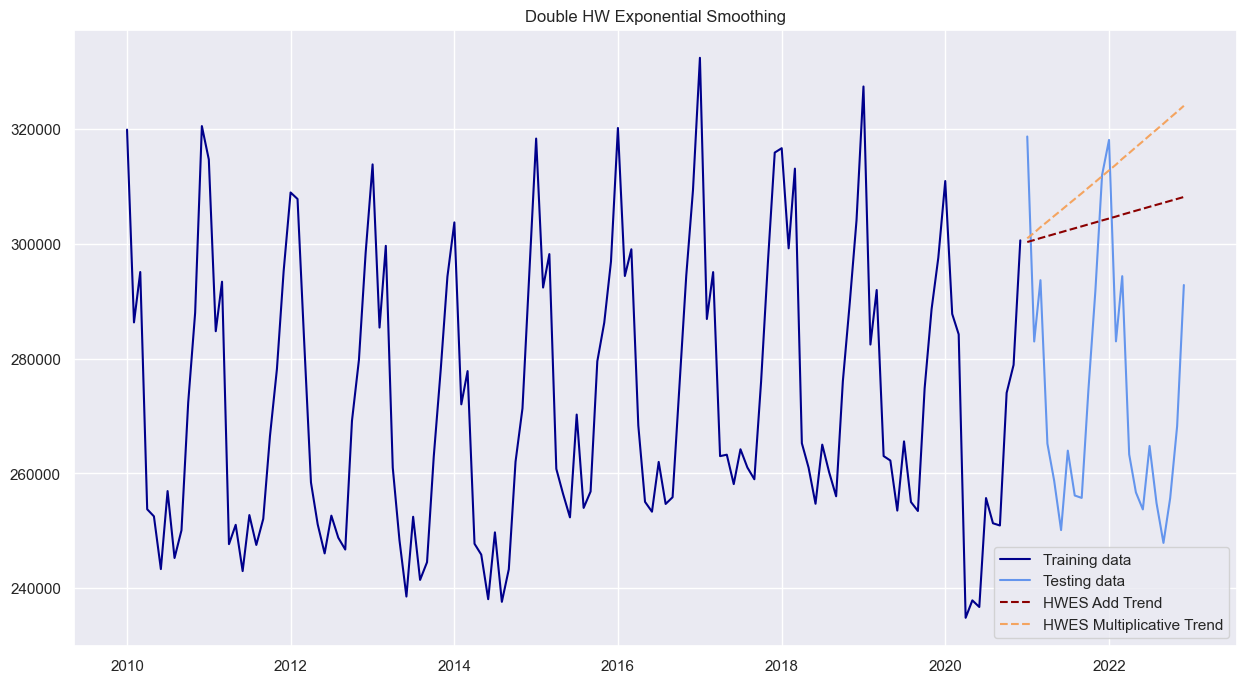

In [205]:
plt.figure(figsize=(15,8))
plt.plot(train_series_overall, color='darkblue', label="Training data")
plt.plot(test_series_overall, color='cornflowerblue', label="Testing data")
plt.plot(HWES_model1_overall_pred, color='darkred', label=r"HWES Add Trend", linestyle="dashed")
plt.plot(HWES_model2_overall_pred, color='sandybrown', label=r"HWES Multiplicative Trend", linestyle="dashed")
plt.legend()
plt.title("Double HW Exponential Smoothing")
plt.show()

It can be seend that the predictions are still not accurate as they do not take account the seasonality, which is more clearly present in the data than the overall trend. Multiplicative trend shows much larger positive trend compared to additive trend. 

Finally, we will use Triple HWES which takes into account seasonality in addition to trend. Both 'additive' and 'multiplicative' seasons are compared. 

In [206]:
HWES_model1_overall = ExponentialSmoothing(train_series_overall, trend='add', seasonal='add',  initialization_method="estimated")
HWES_model2_overall = ExponentialSmoothing(train_series_overall, trend='add', seasonal='mul',  initialization_method="estimated")

HWES_model1_overall_fit = HWES_model1_overall.fit()
HWES_model2_overall_fit = HWES_model2_overall.fit()

HWES_model1_overall_pred = HWES_model1_overall_fit.forecast(48)
HWES_model2_overall_pred = HWES_model2_overall_fit.forecast(48)

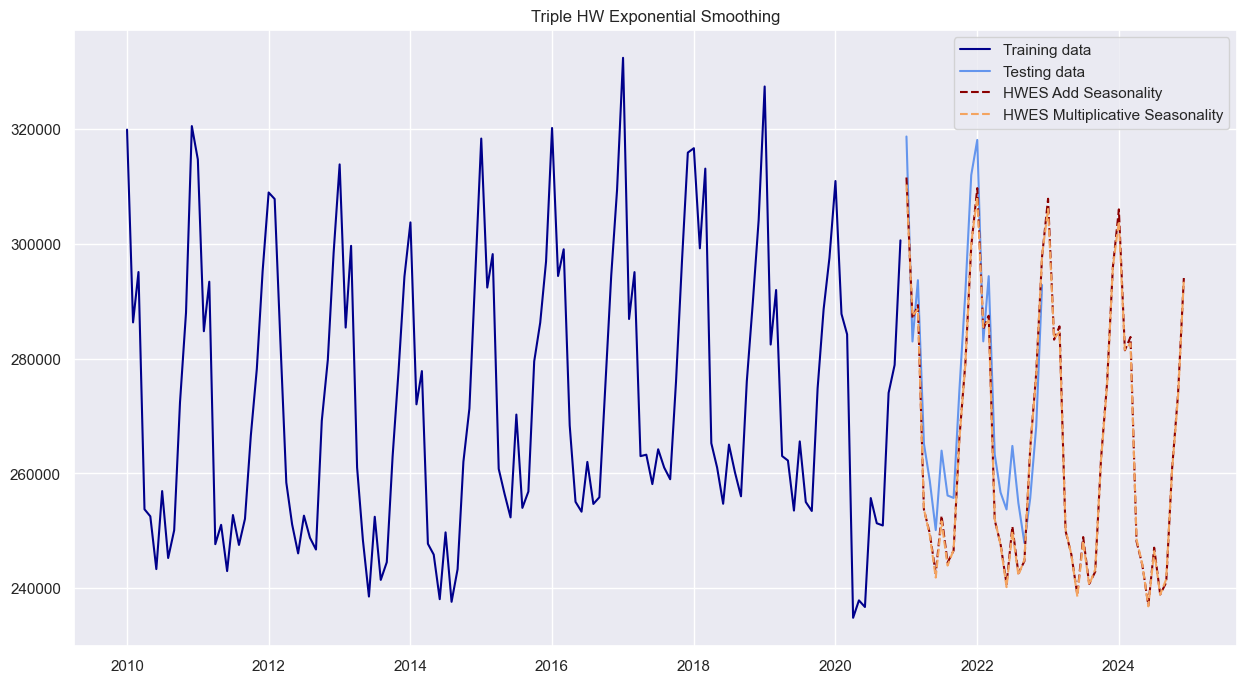

In [207]:
plt.figure(figsize=(15,8))
plt.plot(train_series_overall, color='darkblue', label="Training data")
plt.plot(test_series_overall, color='cornflowerblue', label="Testing data")
plt.plot(HWES_model1_overall_pred, color='darkred', label=r"HWES Add Seasonality", linestyle="dashed")
plt.plot(HWES_model2_overall_pred, color='sandybrown', label=r"HWES Multiplicative Seasonality", linestyle="dashed")
plt.legend()
plt.title("Triple HW Exponential Smoothing")
plt.show()

As expected, when seasonality is added to the method, the predictions are getting more closer to the true values. 'Additive' and 'multiplicative' seasonality have small differences but as stated during the data exploration, the the changes in seasonal variations (decreasing) propotional to the time are relatively small. Therefore, **'additive' seasonality** will be chosen for the final method.  

The performance of the final model will be evaluated with (Root) Mean Squared Error ((R)MSE), Mean Absolute Error (MAE) and AIC-score.

In [208]:
HWES_overall_perf = model_performance_eval(HWES_model1_overall_fit, test_series_overall)

print(f"MSE: {round(HWES_overall_perf[0], 2)}")
print(f"RMSE: {round(HWES_overall_perf[1], 2)}")
print(f"MAE: {round(HWES_overall_perf[2], 2)}")
print(f"AIC-score: {round(HWES_overall_perf[3], 2)}")

MSE: 88754100.65
RMSE: 9420.94
MAE: 8841.16
AIC-score: 2335.07


### 4.1.2 Fossil Fuels

Next, we will examine *Fossil fuels* with Triple HWES as it was earlier demonstrated that the method leads to better predictions as seasonality and trend are taken into consideration. As seen during STL, the negative trend seems more linear than exponential, *additive trend* will be used in the model. In addition, the change in the seasonality was relatively stable across time, **additive seasonality** will be used.

In [209]:
HWES_model_ff = ExponentialSmoothing(train_series_ff, trend='add', seasonal='add',  initialization_method="estimated")
HWES_model_ff_fit = HWES_model_ff.fit()
HWES_model_ff_pred = HWES_model_ff_fit.forecast(48)

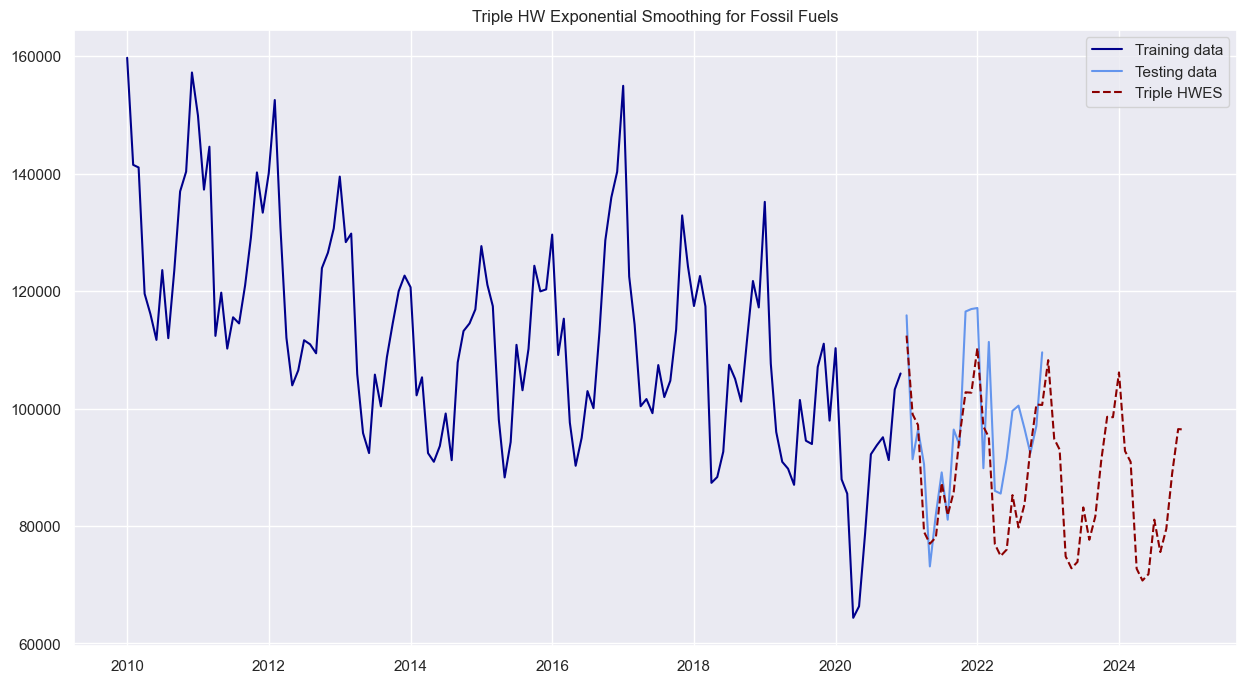

In [210]:
plt.figure(figsize=(15,8))
plt.plot(train_series_ff, color='darkblue', label="Training data")
plt.plot(test_series_ff, color='cornflowerblue', label="Testing data")
plt.plot(HWES_model_ff_pred, color='darkred', label=r"Triple HWES", linestyle="dashed")
plt.legend()
plt.title("Triple HW Exponential Smoothing for Fossil Fuels")
plt.show()

Next, the performance metrics for the model are calculated.

In [211]:
HWES_ff_perf = model_performance_eval(HWES_model_ff_fit, test_series_ff)

print(f"MSE: {round(HWES_ff_perf[0], 2)}")
print(f"RMSE: {round(HWES_ff_perf[1], 2)}")
print(f"MAE: {round(HWES_ff_perf[2], 2)}")
print(f"AIC-score: {round(HWES_ff_perf[3], 2)}")

MSE: 101511767.39
RMSE: 10075.3
MAE: 8349.69
AIC-score: 2369.59


### 4.1.3 Renewables

For *Renewables*, Triple HWES will be used. As the trend seems to be faily linear, **additive trend** will be used. In addition, as stated duting data exploration, the changes in seasonality seems to increase across time so **seasonality** is considered to be **multiplicative**. 

In [212]:
HWES_model_r = ExponentialSmoothing(train_series_r, trend='add', seasonal='mul',  initialization_method="estimated")
HWES_model_r_fit = HWES_model_r.fit()

HWES_model_r_pred = HWES_model_r_fit.forecast(48)

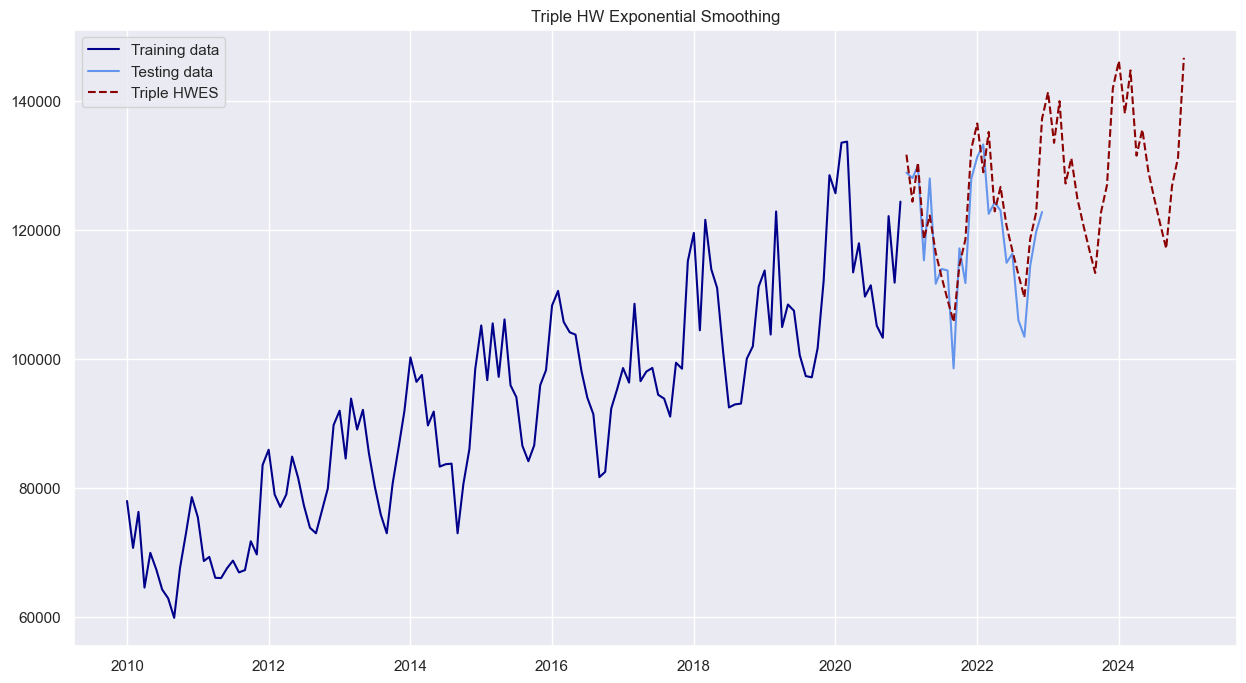

In [213]:
plt.figure(figsize=(15,8))
plt.plot(train_series_r, color='darkblue', label="Training data")
plt.plot(test_series_r, color='cornflowerblue', label="Testing data")
plt.plot(HWES_model_r_pred, color='darkred', label=r"Triple HWES", linestyle="dashed")
plt.legend()
plt.title("Triple HW Exponential Smoothing")
plt.show()

The performance metrics for the model are calculated.

In [214]:
HWES_r_perf = model_performance_eval(HWES_model_r_fit, test_series_r)

print(f"MSE: {round(HWES_r_perf[0], 2)}")
print(f"RMSE: {round(HWES_r_perf[1], 2)}")
print(f"MAE: {round(HWES_r_perf[2], 2)}")
print(f"AIC-score: {round(HWES_r_perf[3], 2)}")

MSE: 33977145.17
RMSE: 5828.99
MAE: 4834.29
AIC-score: 2263.47


### 4.1.4 Nuclear

For *Nuclear*, Tripe HWES will be used with **additive trend** and **additive seasonality**. 

In [215]:
HWES_model_nuclear = ExponentialSmoothing(train_series_nuclear, trend='add', seasonal='add',  initialization_method="estimated")
HWES_model_nuclear_fit = HWES_model_nuclear.fit()
HWES_model_nuclear_pred = HWES_model_nuclear_fit.forecast(48)


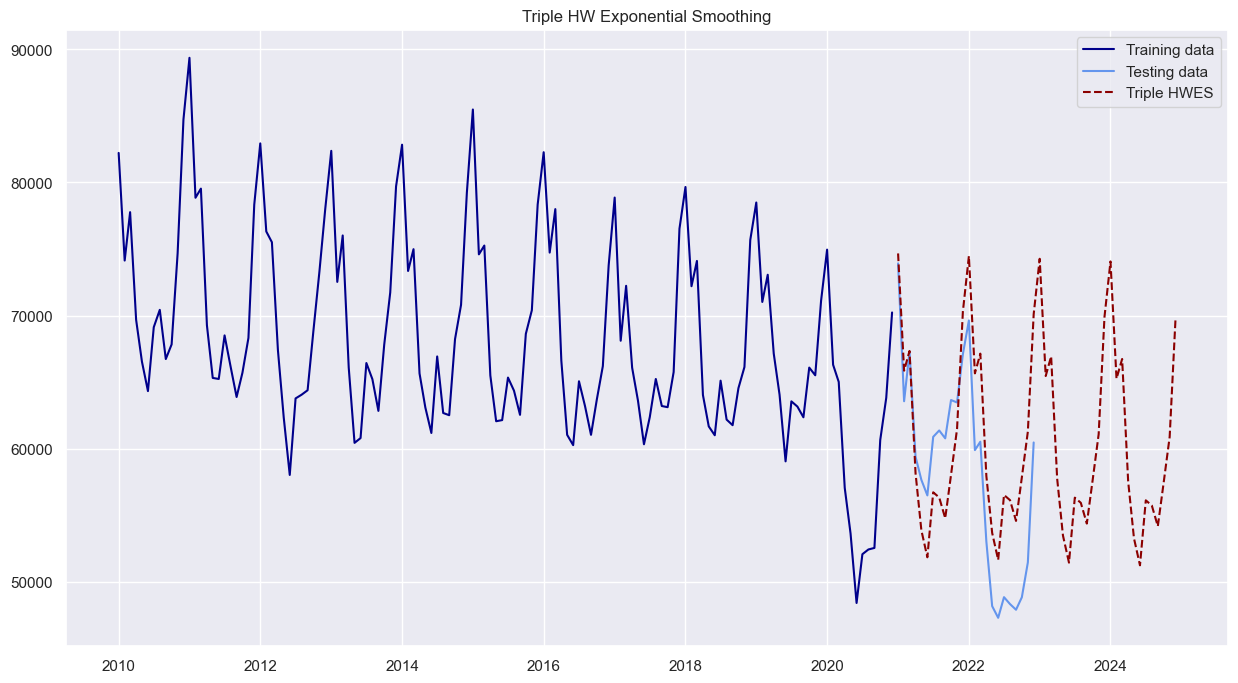

In [216]:
plt.figure(figsize=(15,8))
plt.plot(train_series_nuclear, color='darkblue', label="Training data")
plt.plot(test_series_nuclear, color='cornflowerblue', label="Testing data")
plt.plot(HWES_model_nuclear_pred, color='darkred', label=r"Triple HWES", linestyle="dashed")
plt.legend()
plt.title("Triple HW Exponential Smoothing")
plt.show()

The performacne metrics for the model are the following:

In [217]:
HWES_nuclear_perf = model_performance_eval(HWES_model_nuclear_fit, test_series_nuclear)

print(f"MSE: {round(HWES_nuclear_perf[0], 2)}")
print(f"RMSE: {round(HWES_nuclear_perf[1], 2)}")
print(f"MAE: {round(HWES_nuclear_perf[2], 2)}")
print(f"AIC-score: {round(HWES_nuclear_perf[3], 2)}")

MSE: 32372782.74
RMSE: 5689.71
MAE: 5059.2
AIC-score: 2012.58


## 4.2 (S)ARIMA

The second time-series forecasting algorithm that is considered is ARIMA. As the data includes seasonality, SARIMA will be used to take the seasonality into account. 

### 4.2.1 Net electricity production

Fist we will examine *Net electricity production*.

As we saw in the ADF test, the data is non-stationary. Therefore, we need to differentiate the data to make it stationary. First, **first-order differencing** for the trend is done by by shifting the values by 1. After this, ADF test it repeated to recheck the stationarity.

Test Statistic: -3.531
p-value: 0.007
Critical values:
  1%: -3.478
  5%: -2.882
  10%: -2.578
Based on the p-value, we reject the hypothesis that the data has unit root. Therefore, the data is stationary.


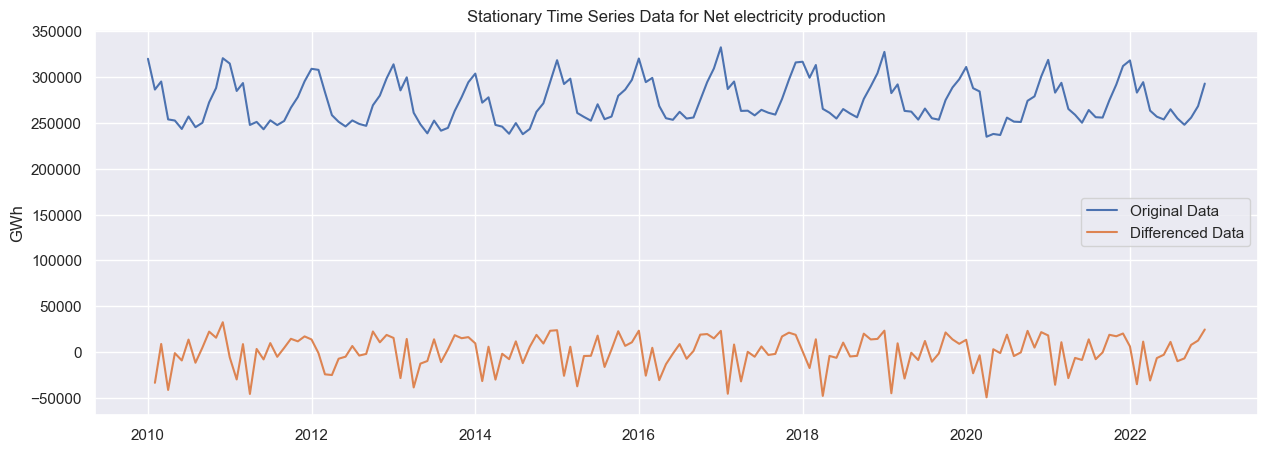

In [218]:
series_overall_diff = series_overall - series_overall.shift(1) # Computes the first difference: y_new = y_now - y_before
series_overall_diff = series_overall_diff.dropna() # Drop missing values
adf(series_overall_diff)

plt.figure(figsize=(15, 5))
plt.plot(series_overall, label='Original Data')
plt.plot(series_overall_diff, label='Differenced Data')
plt.ylabel('GWh')
plt.title('Stationary Time Series Data for Net electricity production')
plt.legend()
plt.show()

We can see that the differenciated data is stationary and therefore, parameter *d* (degree of differenciating) will be 1. However, as the data is seasonal, we also need to do **seasonal differencing** by shifting the values by 12. 

Test Statistic: -5.156
p-value: 0.0
Critical values:
  1%: -3.482
  5%: -2.884
  10%: -2.579
Based on the p-value, we reject the hypothesis that the data has unit root. Therefore, the data is stationary.


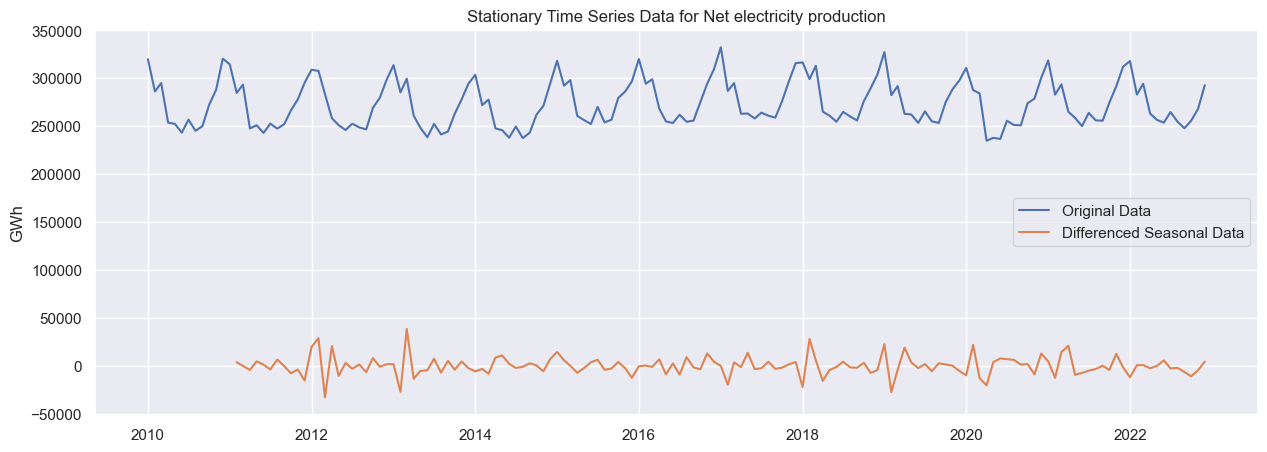

In [219]:
series_overall_diff_seasonal = series_overall_diff - series_overall_diff.shift(12) # Computes the first difference: y_new = y_now - y_before
series_overall_diff_seasonal = series_overall_diff_seasonal.dropna() # Drop missing values
adf(series_overall_diff_seasonal)

plt.figure(figsize=(15, 5))
plt.plot(series_overall, label='Original Data')
plt.plot(series_overall_diff_seasonal, label='Differenced Seasonal Data')
plt.ylabel('GWh')
plt.title('Stationary Time Series Data for Net electricity production')
plt.legend()
plt.show()

We can observe that the data is stationary and trend and seasonality pattern has been removed.

The parameters for the model could be determined by exemining Autocorrelation and Partial Autocorrelation functions (see below). However, here *auto_arima()* function will be used to find optimal parameters for *p*, *P*, *q* and *Q* by comparing the *AIC*-score of each model and choosing the parameters of a model smallst *AIC*-score. *d* and *D* will be set to 1 as first-order differencing and seasonal differencing was done once.

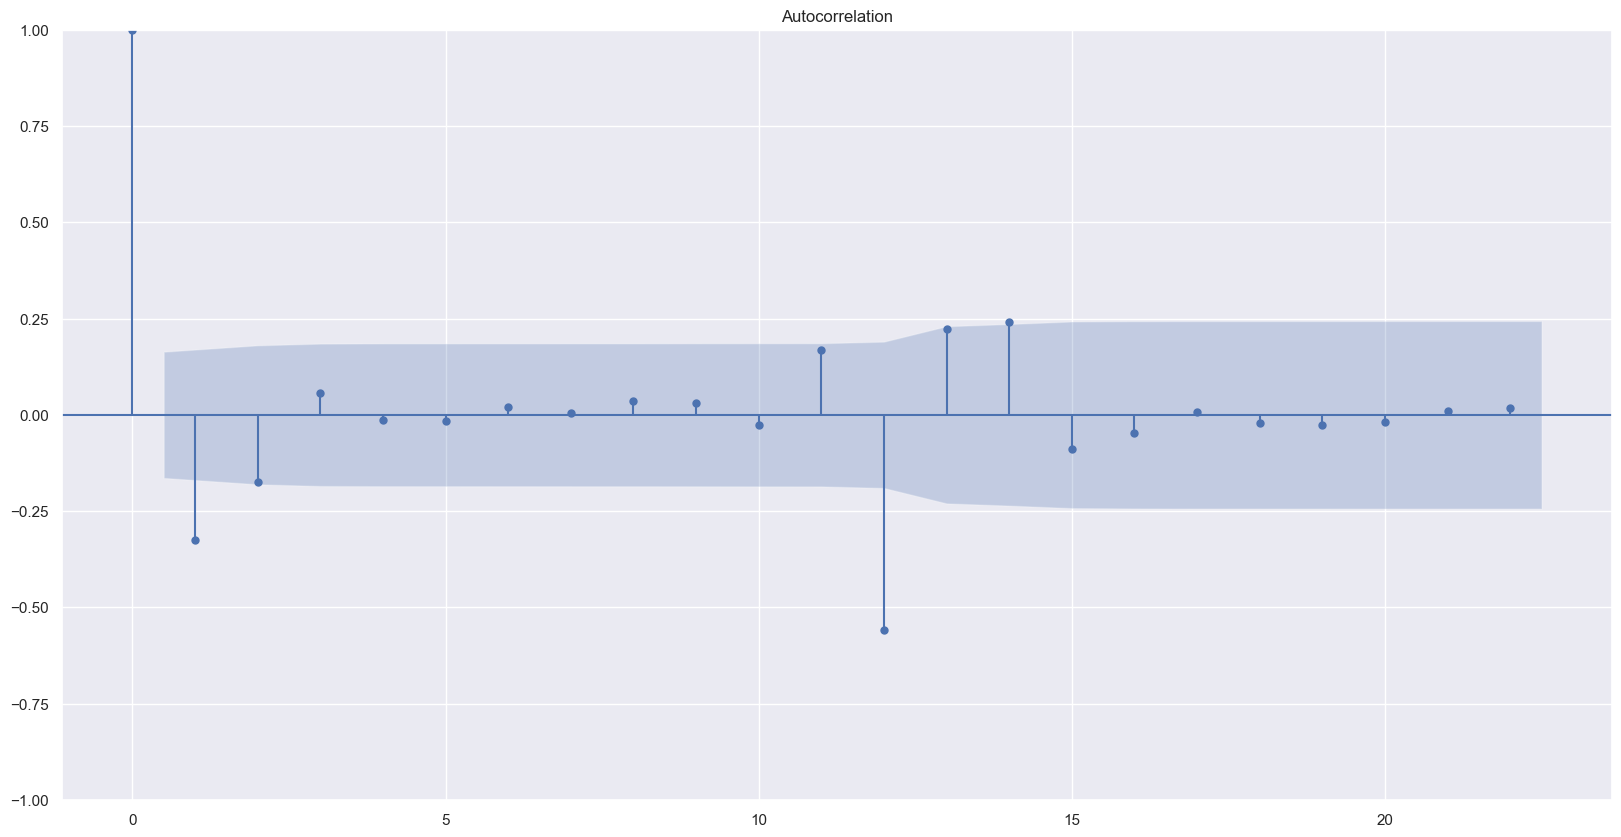

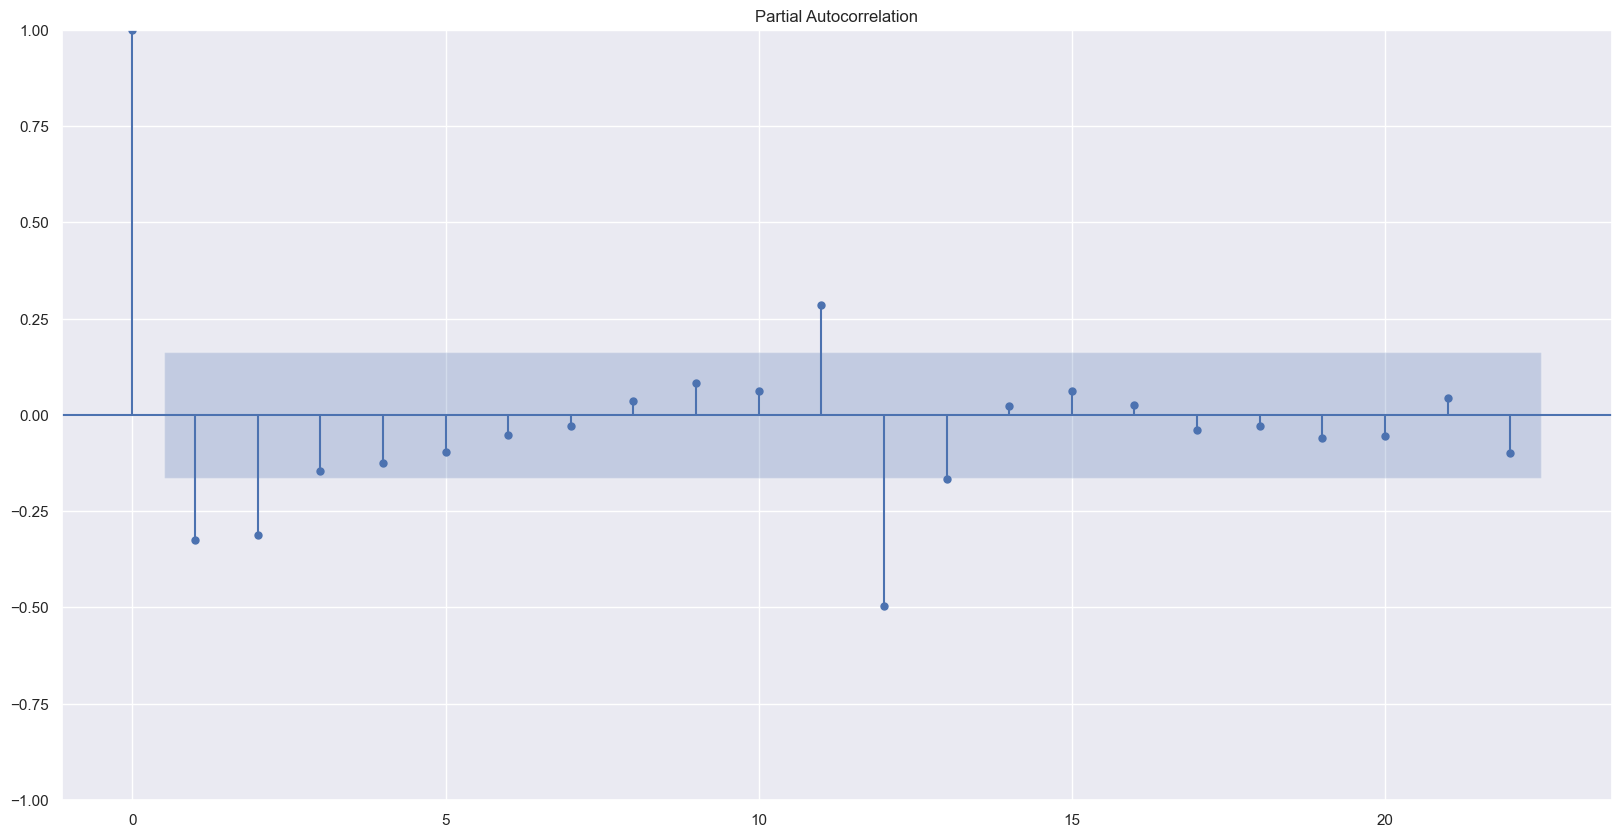

In [220]:
plot_acf(series_overall_diff_seasonal)
plt.show()

plot_pacf(series_overall_diff_seasonal)
plt.show()

In [221]:
lowest_AIC_model = auto_arima(train_series_overall,
                            m=12, # Seasonal length
                            seasonal=True,
                            trace=True, # Shows each step
                            d=1,
                            D=1
                           )
print(lowest_AIC_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=2516.241, Time=1.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2544.261, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2529.114, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2526.665, Time=0.22 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=2522.779, Time=1.14 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=2524.732, Time=1.32 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=inf, Time=2.94 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=inf, Time=2.91 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=2520.082, Time=2.53 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=inf, Time=3.48 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=2522.643, Time=1.15 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=2522.529, Time=0.88 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=2

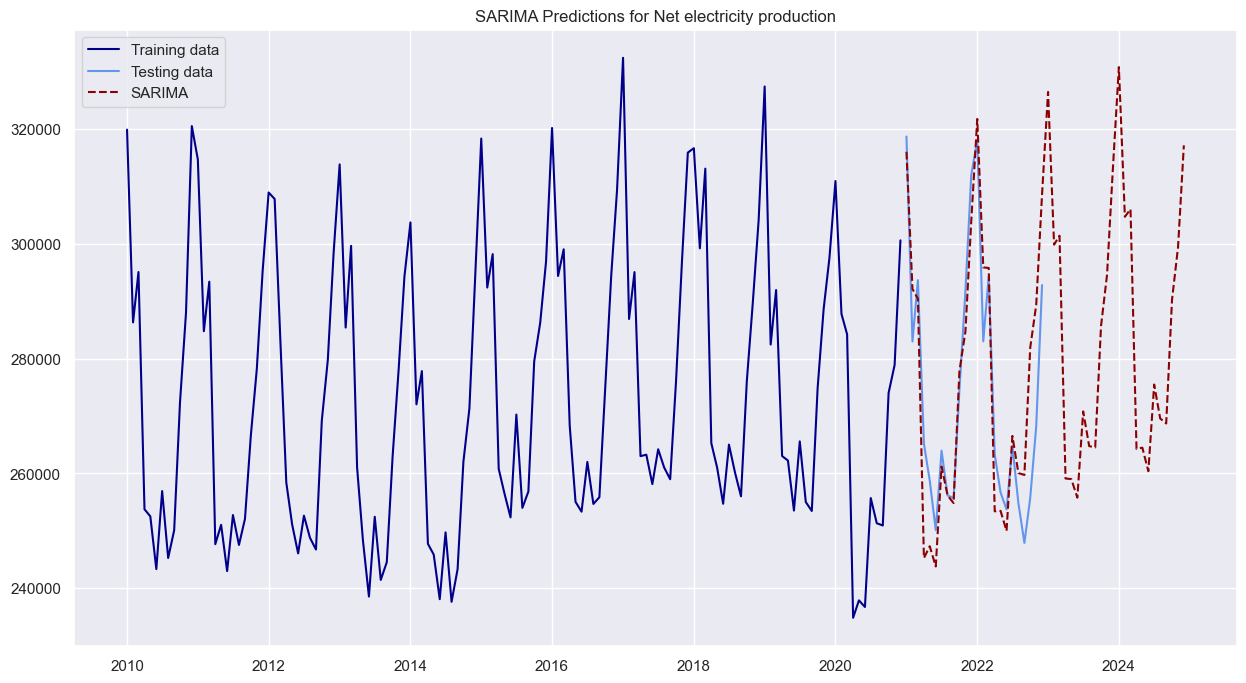

In [222]:
import statsmodels.api as sm

SARIMA_model_overall = sm.tsa.statespace.SARIMAX(train_series_overall,order=(2, 1, 2),seasonal_order=(1,1,1,12))
SARIMA_overall_model_fit = SARIMA_model_overall.fit()
SARIMA_model_overall_pred = SARIMA_overall_model_fit.forecast(48)

plt.figure(figsize=(15,8))
plt.plot(train_series_overall, color='darkblue', label="Training data")
plt.plot(test_series_overall, color='cornflowerblue', label="Testing data")
plt.plot(SARIMA_model_overall_pred, color='darkred', label=r"SARIMA", linestyle="dashed")
plt.legend()
plt.title("SARIMA Predictions for Net electricity production")
plt.show()


As with HWES, the model performance is evaluated by computing (Root) Mean Squared Error ((R)MSE), Mean Absolute Error (MAE) and AIC-score.

In [223]:
SARIMA_overall_perf = model_performance_eval(SARIMA_overall_model_fit, test_series_overall)

print(f"MSE: {round(SARIMA_overall_perf[0], 2)}")
print(f"RMSE: {round(SARIMA_overall_perf[1], 2)}")
print(f"MAE: {round(SARIMA_overall_perf[2], 2)}")
print(f"AIC-score: {round(SARIMA_overall_perf[3], 2)}")

MSE: 110847734.24
RMSE: 10528.43
MAE: 7981.89
AIC-score: 2516.24


### 4.2.2 Fossil Fuels

Next *Fossil fuels* is examined by using SARIMA. As the data is non-stationary, we will start by differentiating the data.

Test Statistic: -3.596
p-value: 0.006
Critical values:
  1%: -3.478
  5%: -2.882
  10%: -2.578
Based on the p-value, we reject the hypothesis that the data has unit root. Therefore, the data is stationary.


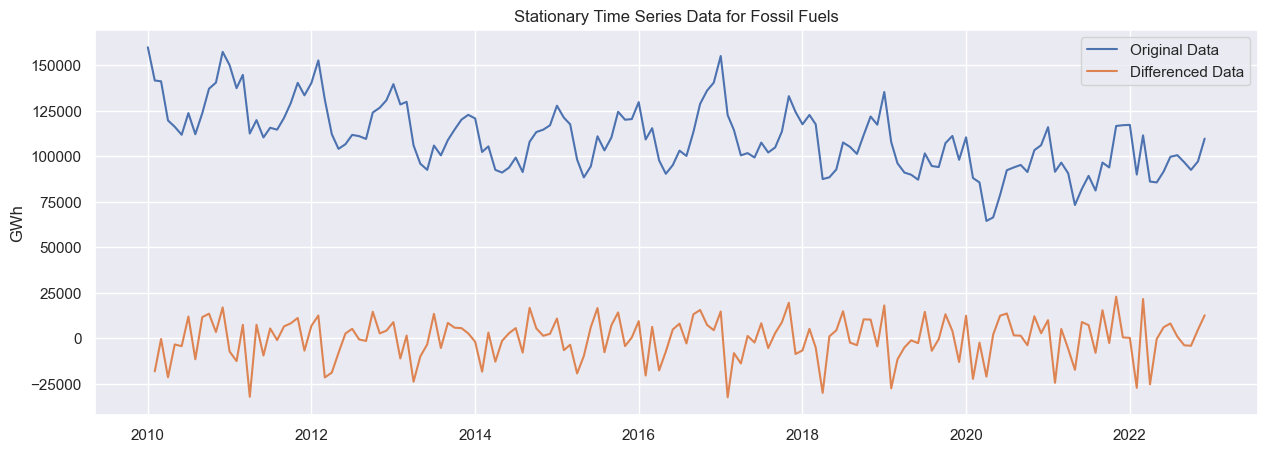

In [224]:
series_ff_diff = series_ff - series_ff.shift(1) # Computes the first difference: y_new = y_now - y_before
series_ff_diff = series_ff_diff.dropna() # Drop missing values
adf(series_ff_diff)

plt.figure(figsize=(15, 5))
plt.plot(series_ff, label='Original Data')
plt.plot(series_ff_diff, label='Differenced Data')
plt.ylabel('GWh')
plt.title('Stationary Time Series Data for Fossil Fuels')
plt.legend()
plt.show()

Test Statistic: -5.349
p-value: 0.0
Critical values:
  1%: -3.482
  5%: -2.884
  10%: -2.579
Based on the p-value, we reject the hypothesis that the data has unit root. Therefore, the data is stationary.


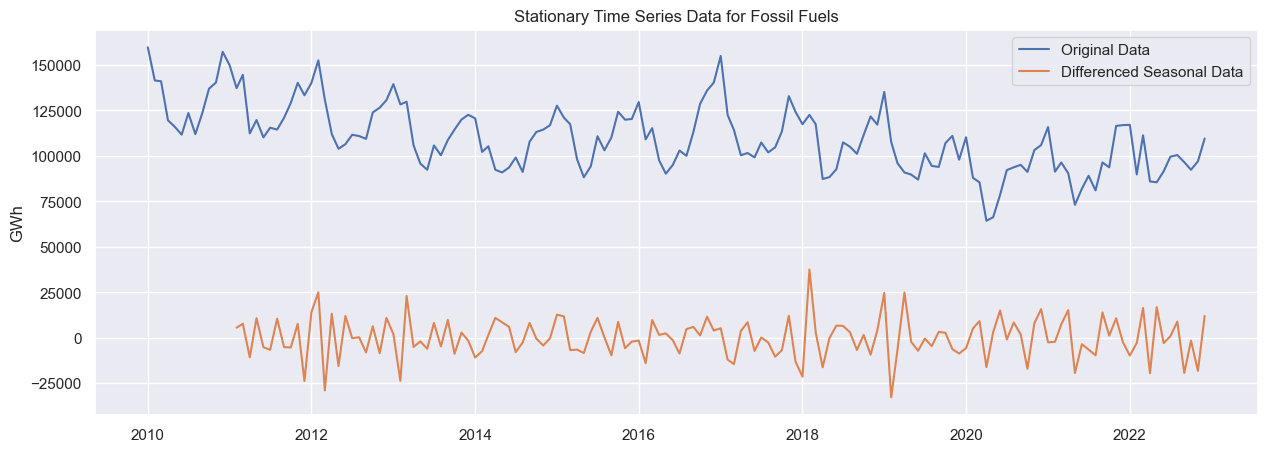

In [225]:
series_ff_diff_seasonal = series_ff_diff - series_ff_diff.shift(12) # Computes the first difference: y_new = y_now - y_before
series_ff_diff_seasonal = series_ff_diff_seasonal.dropna() # Drop missing values
adf(series_ff_diff_seasonal)

plt.figure(figsize=(15, 5))
plt.plot(series_ff, label='Original Data')
plt.plot(series_ff_diff_seasonal, label='Differenced Seasonal Data')
plt.ylabel('GWh')
plt.title('Stationary Time Series Data for Fossil Fuels')
plt.legend()
plt.show()

We can see the data has become stationary so *d* and *D* will be 1. Next, grid search is used to find optimal parameters for the rest of the model.

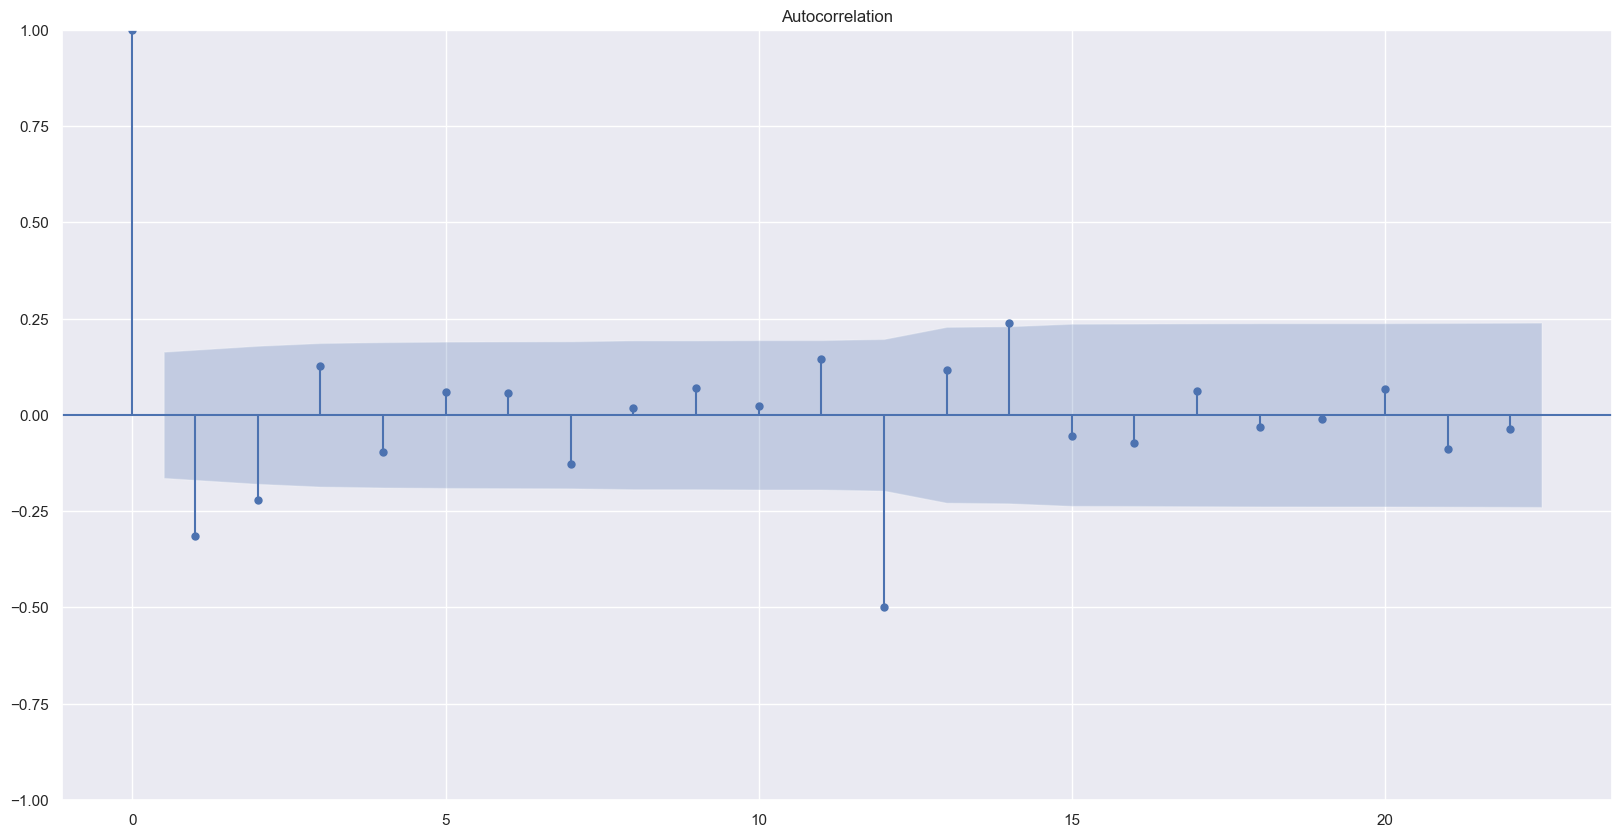

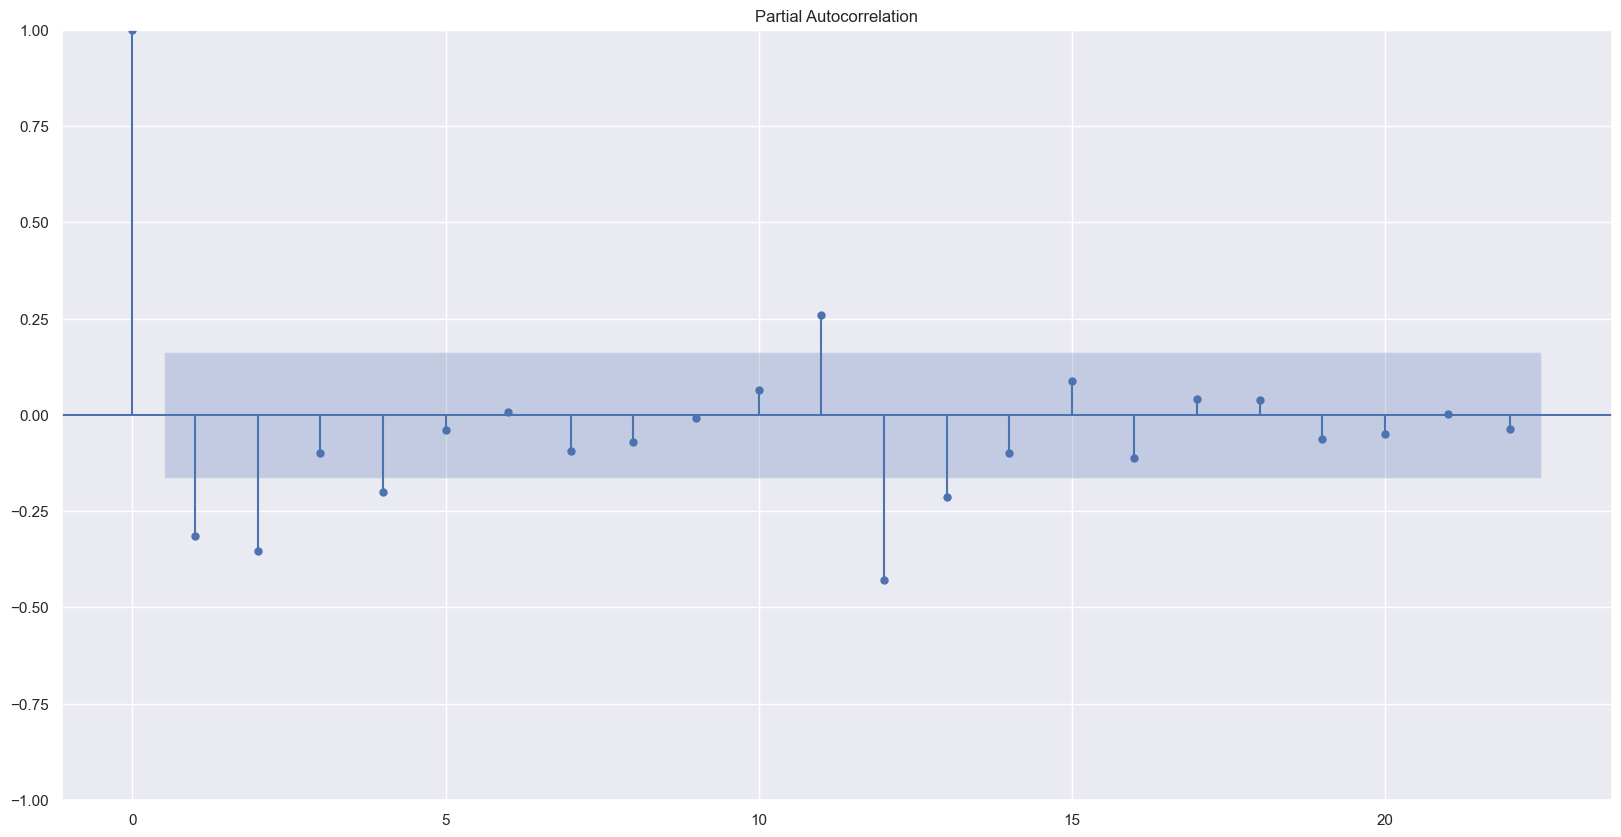

In [226]:
plot_acf(series_ff_diff_seasonal)
plt.show()

plot_pacf(series_ff_diff_seasonal)
plt.show()

In [227]:
lowest_AIC_model = auto_arima(train_series_ff,
                            m=12, # Seasonal length
                            seasonal=True,
                            trace=True, # Shows each step
                            d=1,
                            D=1
                           )
print(lowest_AIC_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=2508.436, Time=1.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2554.470, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2530.474, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2518.532, Time=0.17 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=2510.982, Time=1.03 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=2518.336, Time=0.81 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=2510.404, Time=3.39 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=inf, Time=2.53 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=2546.024, Time=0.16 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=2508.862, Time=1.84 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=2512.457, Time=2.44 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=inf, Time=3.08 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=2512.024, Time=0.46 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=2510.419, Time=0.52 sec
 ARIMA(3,1,2)(1,1,1)[12]     

After finding the parameters, we can fit the final model. 

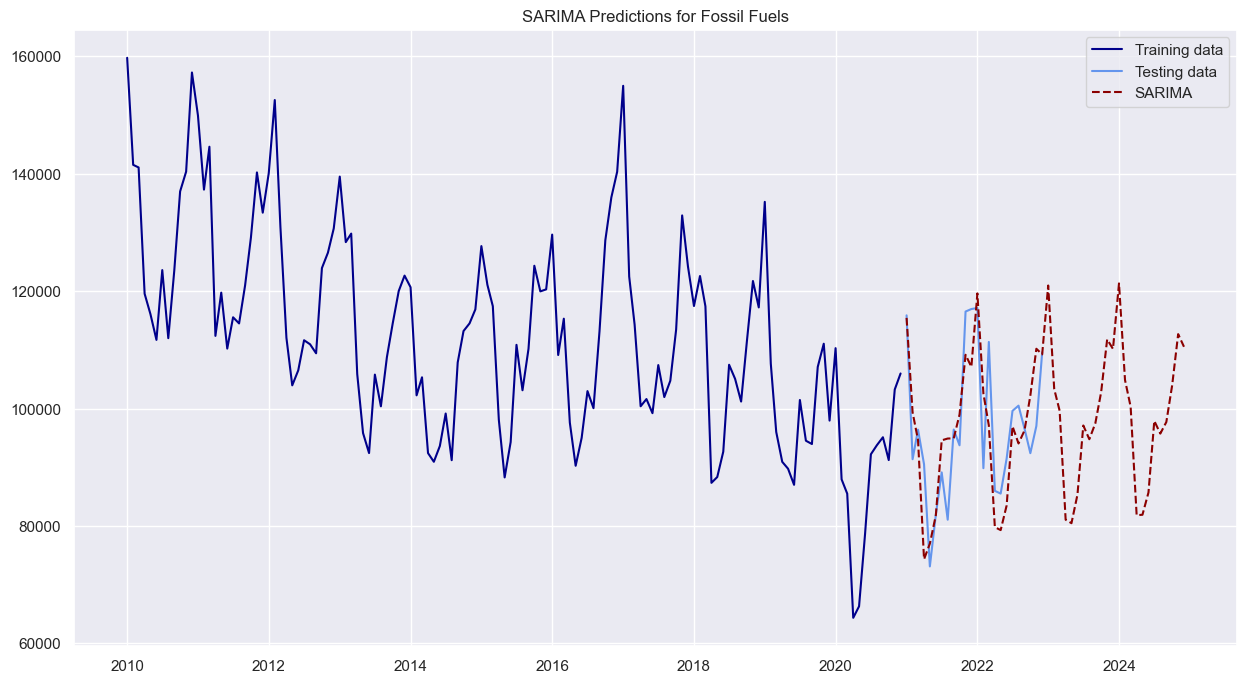

In [228]:
import statsmodels.api as sm

SARIMA_ff_model = sm.tsa.statespace.SARIMAX(train_series_ff,order=(2, 1, 2),seasonal_order=(1,1,1,12))
SARIMA_ff_model_fit = SARIMA_ff_model.fit()
SARIMA_ff_model_pred = SARIMA_ff_model_fit.forecast(48)

plt.figure(figsize=(15,8))
plt.plot(train_series_ff, color='darkblue', label="Training data")
plt.plot(test_series_ff, color='cornflowerblue', label="Testing data")
plt.plot(SARIMA_ff_model_pred, color='darkred', label=r"SARIMA", linestyle="dashed")
plt.legend()
plt.title("SARIMA Predictions for Fossil Fuels")
plt.show()


Next, the metrics for model performance are computed.

In [229]:
SARIMA_ff_perf = model_performance_eval(SARIMA_ff_model_fit, test_series_ff)

print(f"MSE: {round(SARIMA_ff_perf[0], 2)}")
print(f"RMSE: {round(SARIMA_ff_perf[1], 2)}")
print(f"MAE: {round(SARIMA_ff_perf[2], 2)}")
print(f"AIC-score: {round(SARIMA_ff_perf[3], 2)}")

MSE: 65553972.99
RMSE: 8096.54
MAE: 6502.13
AIC-score: 2508.44


### 4.2.3 Nuclear

Next, *Nuclear* will be predicted by using SARIMA. First, the data is again differentiated. 

Test Statistic: -3.678
p-value: 0.004
Critical values:
  1%: -3.477
  5%: -2.882
  10%: -2.578
Based on the p-value, we reject the hypothesis that the data has unit root. Therefore, the data is stationary.


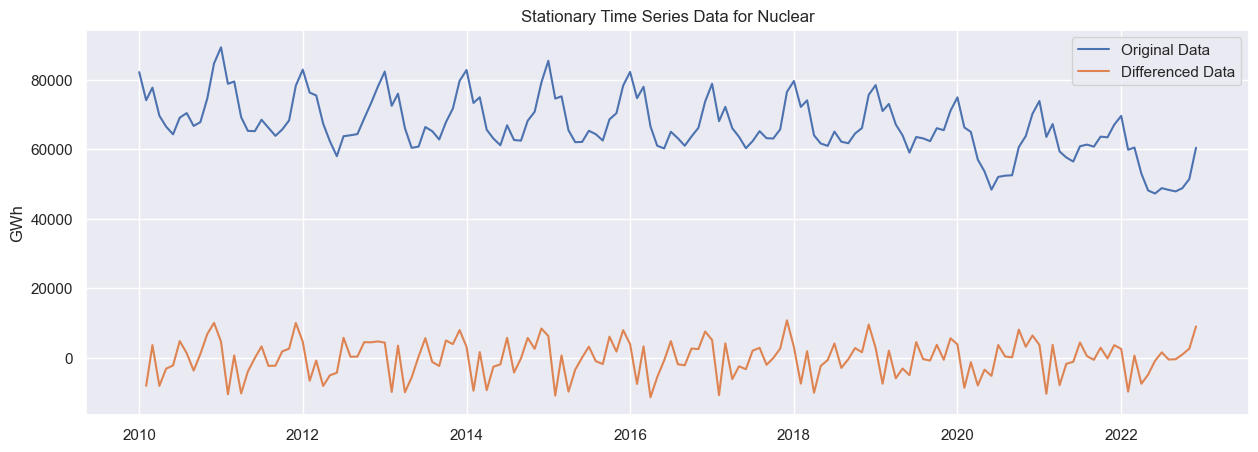

In [230]:
series_nuclear_diff = series_nuclear - series_nuclear.shift(1) # Computes the first difference: y_new = y_now - y_before
series_nuclear_diff = series_nuclear_diff.dropna() # Drop missing values
adf(series_nuclear_diff)

plt.figure(figsize=(15, 5))
plt.plot(series_nuclear, label='Original Data')
plt.plot(series_nuclear_diff, label='Differenced Data')
plt.ylabel('GWh')
plt.title('Stationary Time Series Data for Nuclear')
plt.legend()
plt.show()

Test Statistic: -5.551
p-value: 0.0
Critical values:
  1%: -3.482
  5%: -2.884
  10%: -2.579
Based on the p-value, we reject the hypothesis that the data has unit root. Therefore, the data is stationary.


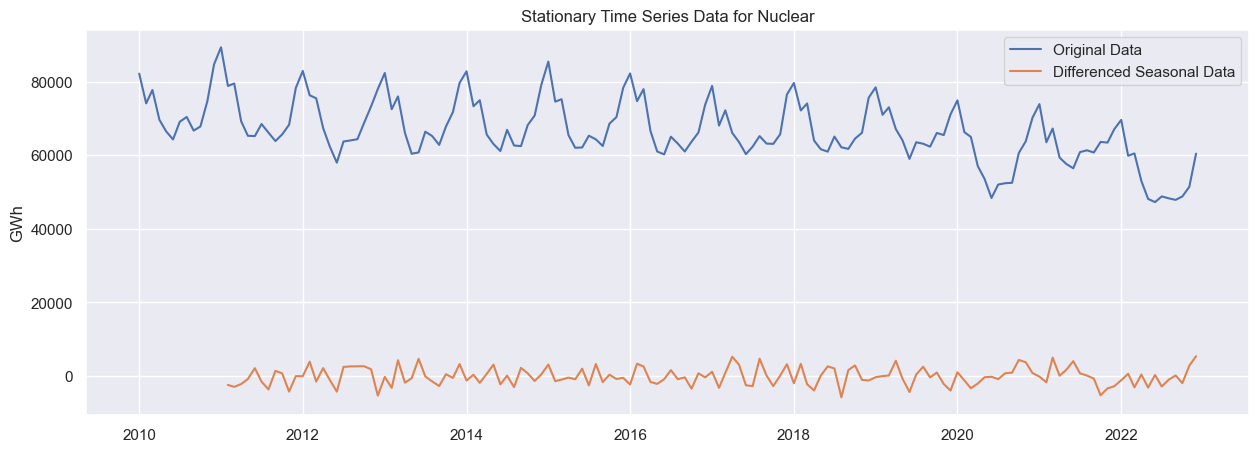

In [231]:
series_nuclear_diff_seasonal = series_nuclear_diff - series_nuclear_diff.shift(12) # Computes the first difference: y_new = y_now - y_before
series_nuclear_diff_seasonal = series_nuclear_diff_seasonal.dropna() # Drop missing values
adf(series_nuclear_diff_seasonal)

plt.figure(figsize=(15, 5))
plt.plot(series_nuclear, label='Original Data')
plt.plot(series_nuclear_diff_seasonal, label='Differenced Seasonal Data')
plt.ylabel('GWh')
plt.title('Stationary Time Series Data for Nuclear')
plt.legend()
plt.show()

The data is stationary and therefore *d* and *D* are 1. Next, we can plot ACF and PACF and *auto_arima* will be used to find optimal parameters for the model.

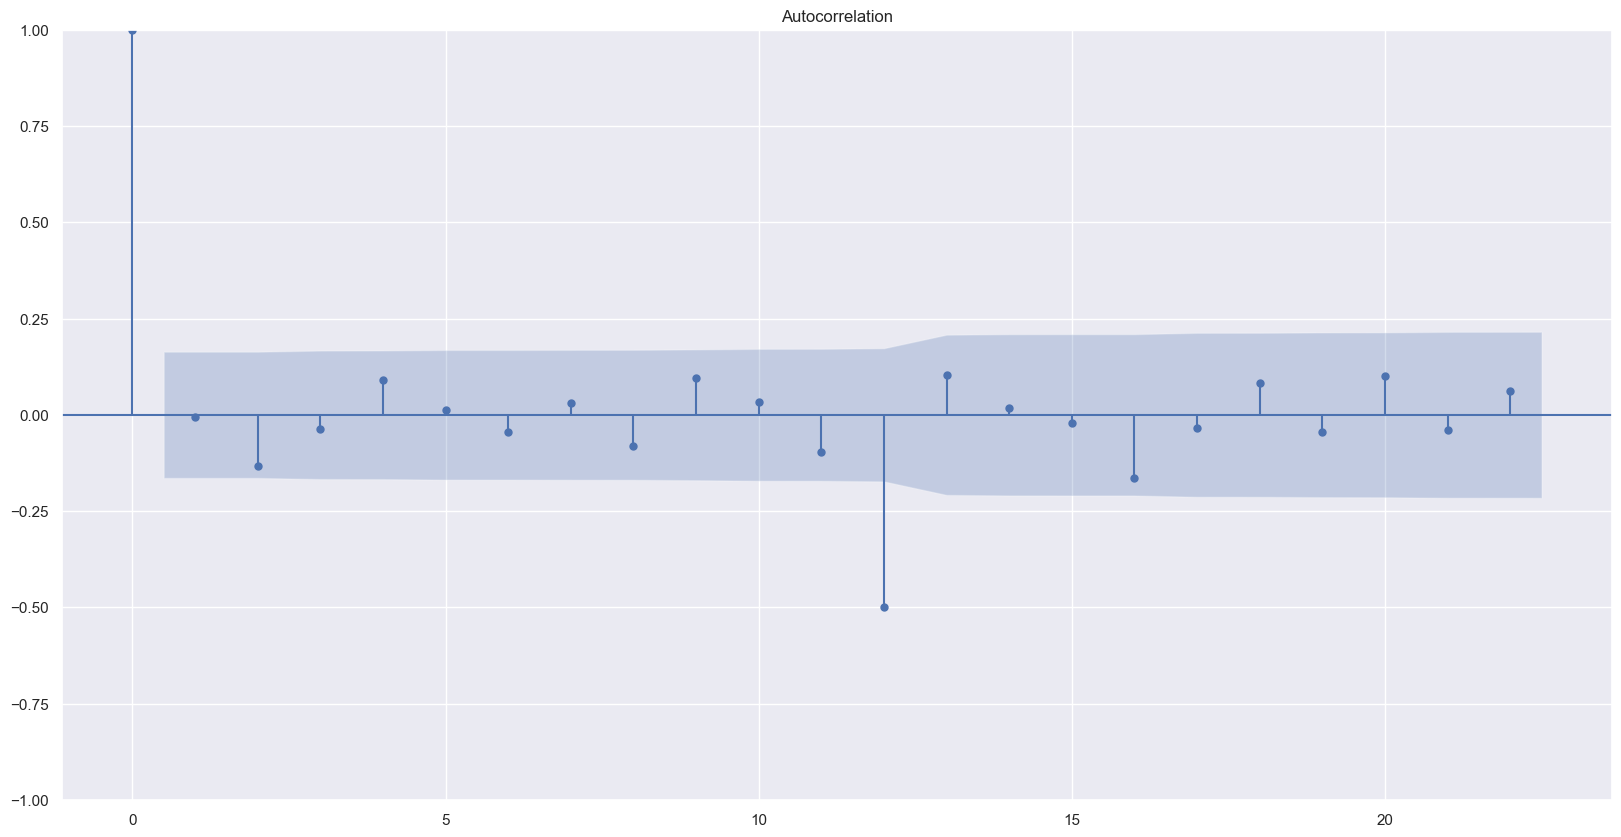

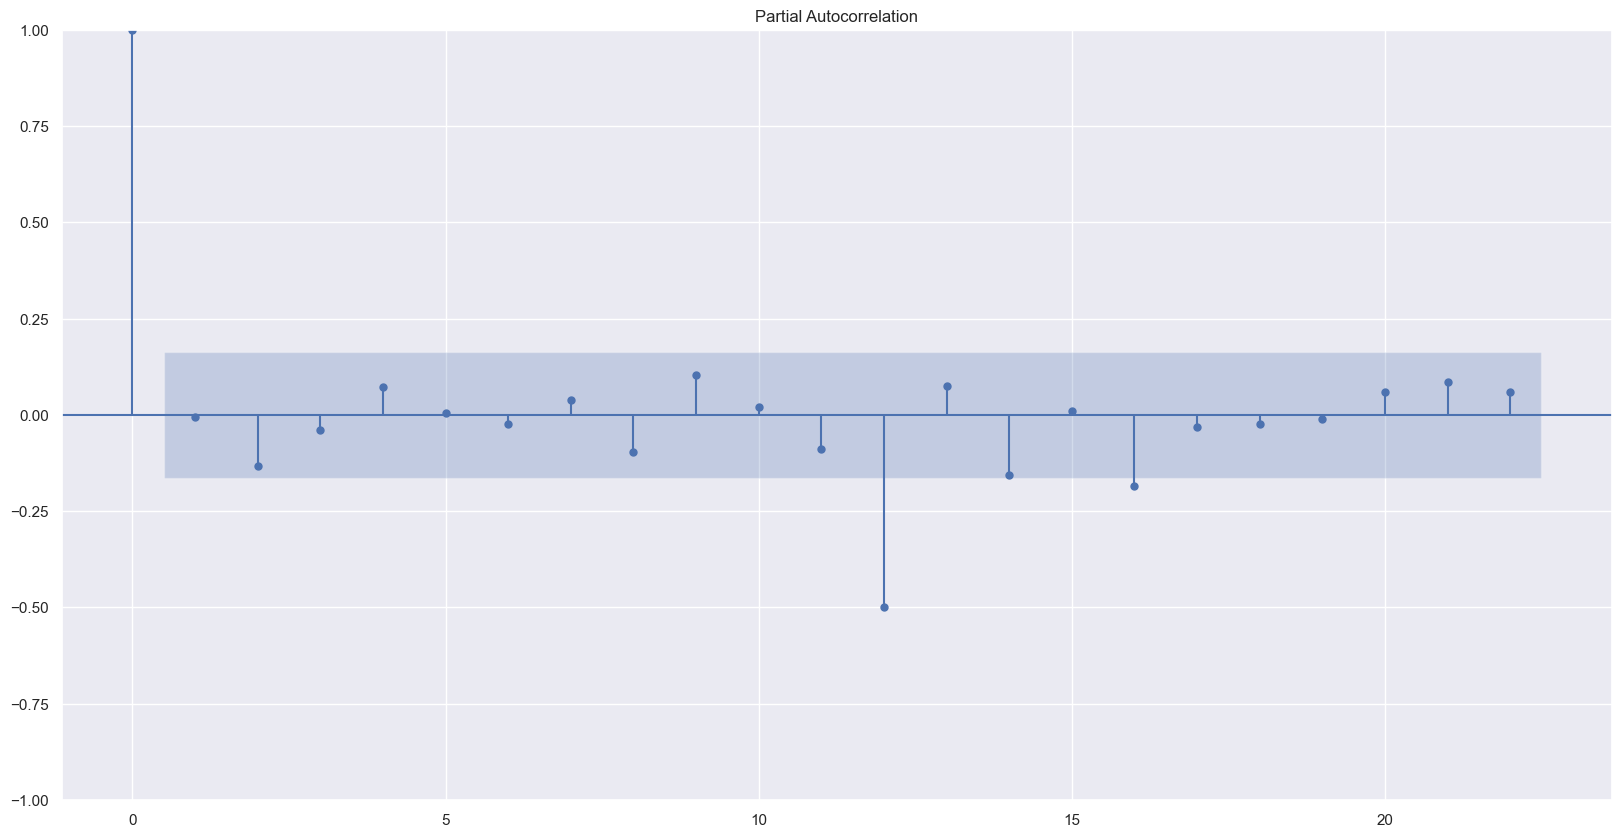

In [232]:
plot_acf(series_nuclear_diff_seasonal)
plt.show()

plot_pacf(series_nuclear_diff_seasonal)
plt.show()

In [233]:
lowest_AIC_model = auto_arima(train_series_nuclear,
                            m=12, # Seasonal length
                            seasonal=True,
                            trace=True, # Shows each step
                            d=1,
                            D=1
                           )
print(lowest_AIC_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=2189.341, Time=1.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2190.026, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2188.650, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2187.904, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2191.622, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2184.270, Time=0.38 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2188.595, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2188.553, Time=0.77 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2188.012, Time=1.11 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2186.728, Time=0.46 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2187.791, Time=0.42 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2185.670, Time=0.61 sec
 ARIMA(0,1,2)(1,1,1)[12]     

Next we can fit the final model.

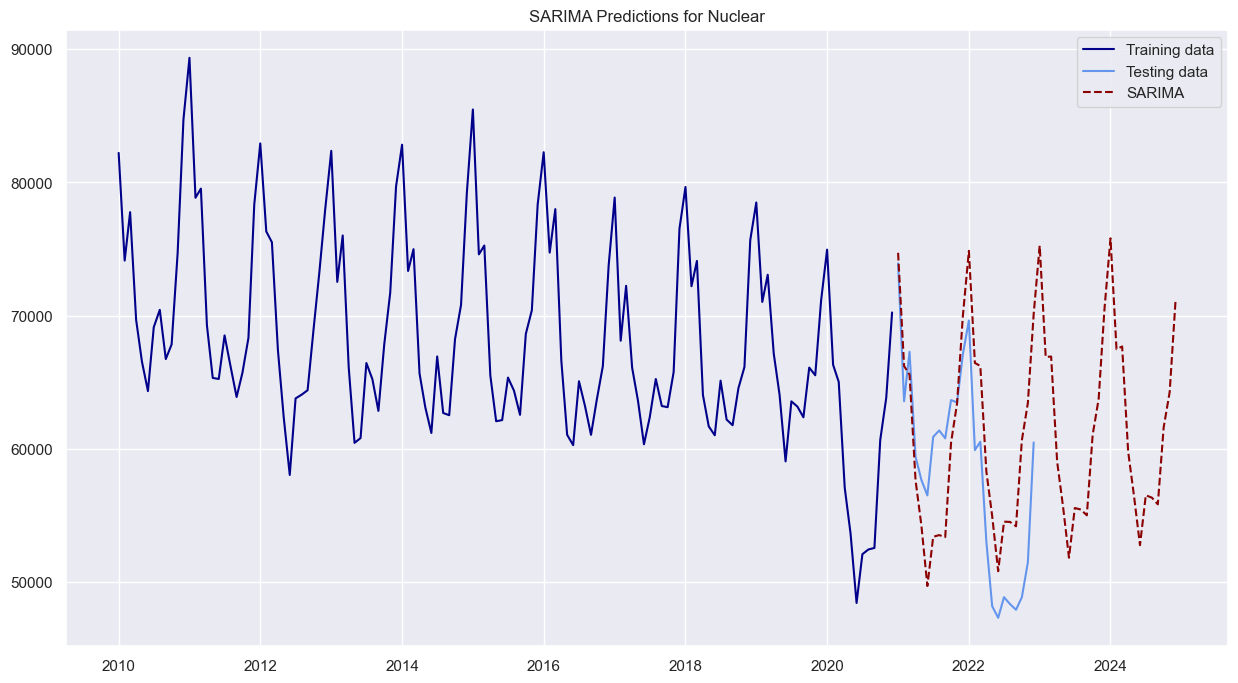

In [234]:
import statsmodels.api as sm

SARIMA_nuclear_model = sm.tsa.statespace.SARIMAX(train_series_nuclear,order=(0, 1, 1),seasonal_order=(1,1,1,12))
SARIMA_nuclear_model_fit = SARIMA_nuclear_model.fit()
SARIMA_nuclear_model_pred = SARIMA_nuclear_model_fit.forecast(48)

plt.figure(figsize=(15,8))
plt.plot(train_series_nuclear, color='darkblue', label="Training data")
plt.plot(test_series_nuclear, color='cornflowerblue', label="Testing data")
plt.plot(SARIMA_nuclear_model_pred, color='darkred', label=r"SARIMA", linestyle="dashed")
plt.legend()
plt.title("SARIMA Predictions for Nuclear")
plt.show()


Finally, the performance metrics for the model are calculated.

In [235]:
SARIMA_nuclear_perf = model_performance_eval(SARIMA_nuclear_model_fit, test_series_nuclear)

print(f"MSE: {round(SARIMA_nuclear_perf[0], 2)}")
print(f"RMSE: {round(SARIMA_nuclear_perf[1], 2)}")
print(f"MAE: {round(SARIMA_nuclear_perf[2], 2)}")
print(f"AIC-score: {round(SARIMA_nuclear_perf[3], 2)}")

MSE: 39065390.09
RMSE: 6250.23
MAE: 5444.15
AIC-score: 2184.27


### 4.2.4 Renewables

Similar to other energy sources, *Renewables* will be predicted by using SARIMA. First, the data is differentiated. 

Test Statistic: -3.787
p-value: 0.003
Critical values:
  1%: -3.478
  5%: -2.882
  10%: -2.578
Based on the p-value, we reject the hypothesis that the data has unit root. Therefore, the data is stationary.


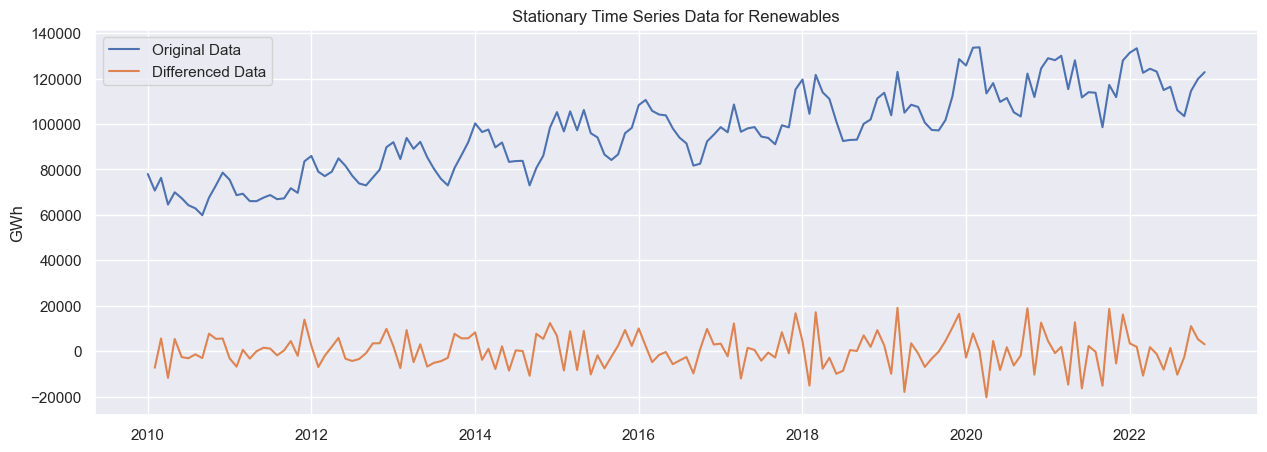

In [236]:
series_r_diff = series_r - series_r.shift(1) # Computes the first difference: y_new = y_now - y_before
series_r_diff = series_r_diff.dropna() # Drop missing values
adf(series_r_diff)

plt.figure(figsize=(15, 5))
plt.plot(series_r, label='Original Data')
plt.plot(series_r_diff, label='Differenced Data')
plt.ylabel('GWh')
plt.title('Stationary Time Series Data for Renewables')
plt.legend()
plt.show()

Test Statistic: -5.239
p-value: 0.0
Critical values:
  1%: -3.482
  5%: -2.884
  10%: -2.579
Based on the p-value, we reject the hypothesis that the data has unit root. Therefore, the data is stationary.


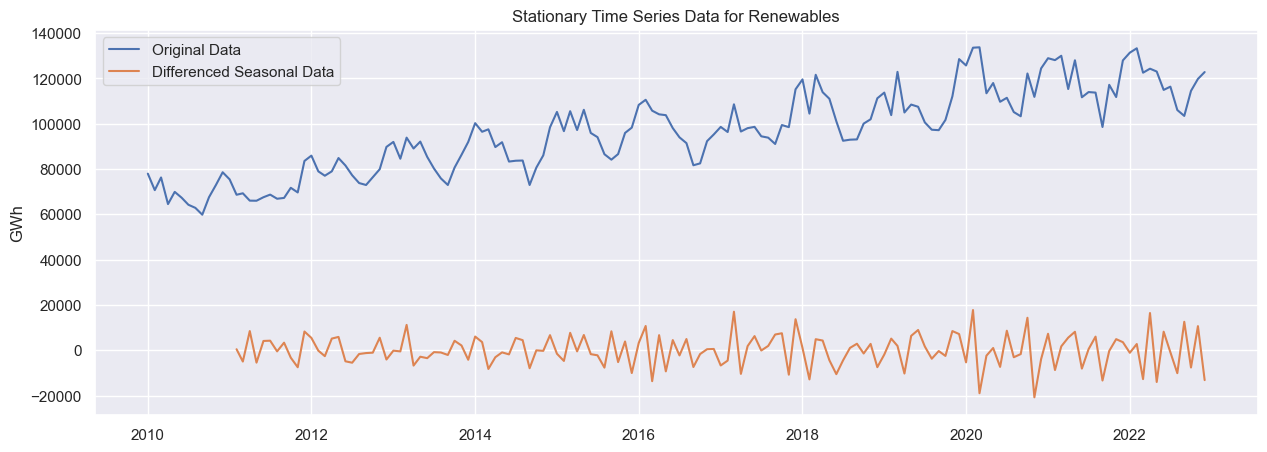

In [237]:
series_r_diff_seasonal = series_r_diff - series_r_diff.shift(12) # Computes the first difference: y_new = y_now - y_before
series_r_diff_seasonal = series_r_diff_seasonal.dropna() # Drop missing values
adf(series_r_diff_seasonal)

plt.figure(figsize=(15, 5))
plt.plot(series_r, label='Original Data')
plt.plot(series_r_diff_seasonal, label='Differenced Seasonal Data')
plt.ylabel('GWh')
plt.title('Stationary Time Series Data for Renewables')
plt.legend()
plt.show()

The data has become stationary so *d* and *D* will be 1. Next, the optimised parameters are found. 

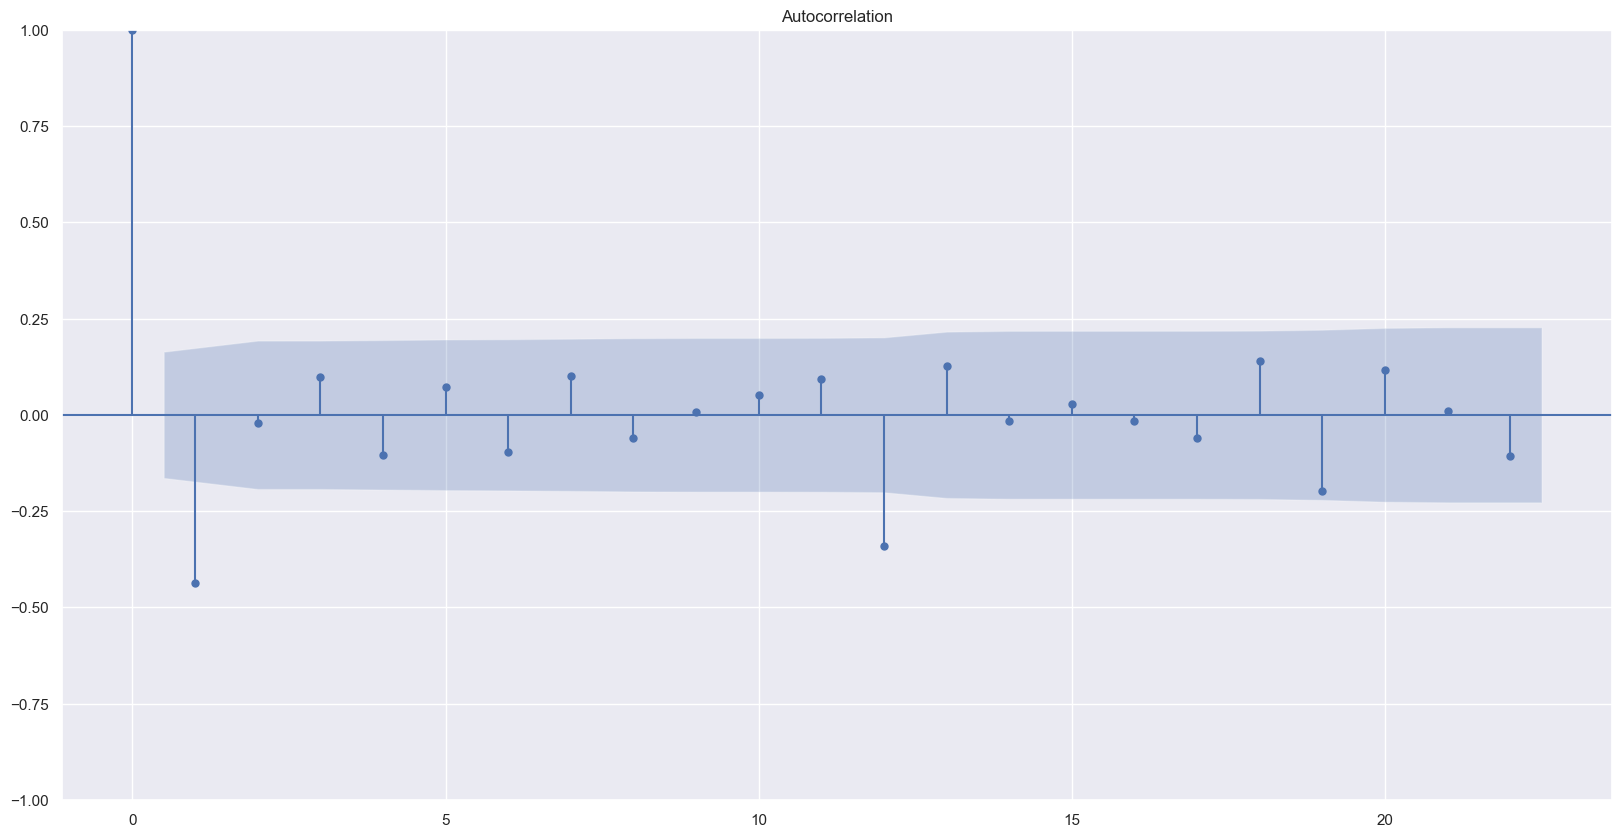

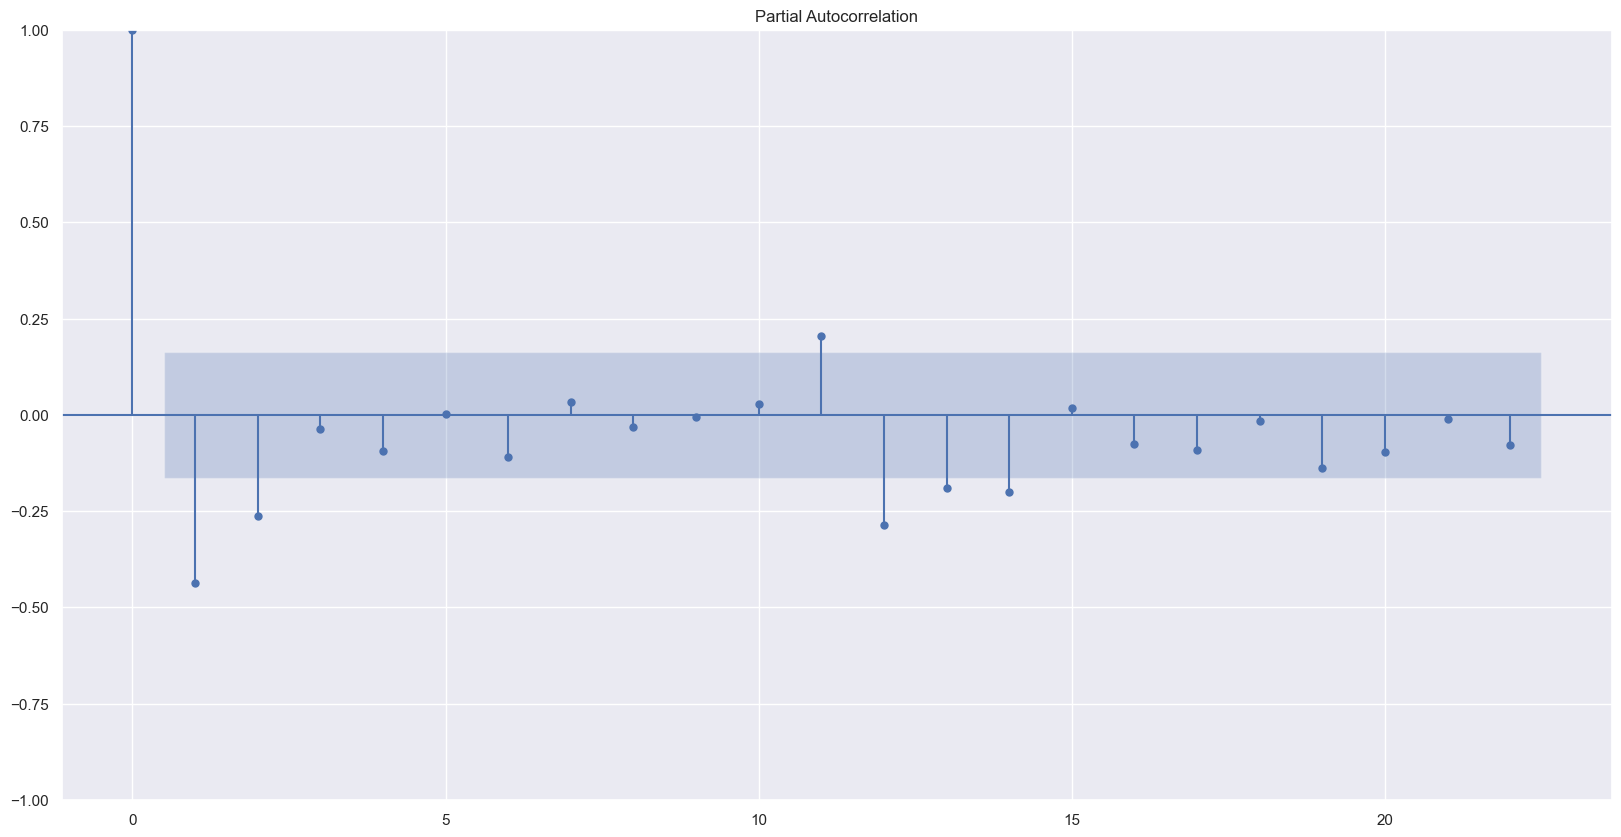

In [238]:
plot_acf(series_r_diff_seasonal)
plt.show()

plot_pacf(series_r_diff_seasonal)
plt.show()

In [239]:
lowest_AIC_model = auto_arima(train_series_r,
                            m=12, # Seasonal length
                            seasonal=True,
                            trace=True, # Shows each step
                            d=1,
                            D=1
                           )
print(lowest_AIC_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=2405.847, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2434.535, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2415.095, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2402.661, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2428.783, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2401.003, Time=0.20 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2414.237, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2402.488, Time=0.61 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2402.694, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2400.711, Time=0.84 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2420.254, Time=0.62 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2402.527, Time=1.04 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2402.744, Time=0.86 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=2402.721, Time=0.84 sec
 ARIMA(1,1,2)(0,1,2

Then we can fit the final model

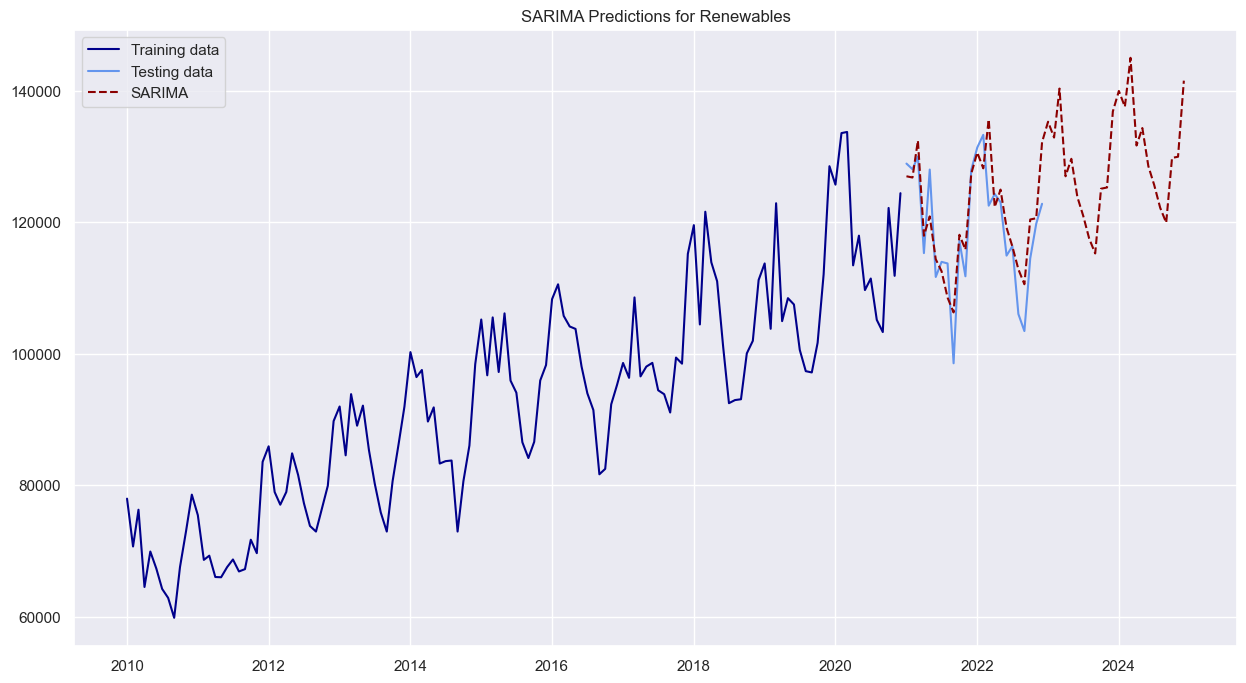

In [240]:
import statsmodels.api as sm

SARIMA_r_model = sm.tsa.statespace.SARIMAX(train_series_r,order=(0, 1, 1),seasonal_order=(0,1,2,12))
SARIMA_r_model_fit = SARIMA_r_model.fit()
SARIMA_r_model_pred = SARIMA_r_model_fit.forecast(48)

plt.figure(figsize=(15,8))
plt.plot(train_series_r, color='darkblue', label="Training data")
plt.plot(test_series_r, color='cornflowerblue', label="Testing data")
plt.plot(SARIMA_r_model_pred, color='darkred', label=r"SARIMA", linestyle="dashed")
plt.legend()
plt.title("SARIMA Predictions for Renewables")
plt.show()


Finally, we can compute the performance metrics.

In [241]:
SARIMA_r_perf = model_performance_eval(SARIMA_r_model_fit, test_series_r)

print(f"MSE: {round(SARIMA_r_perf[0], 2)}")
print(f"RMSE: {round(SARIMA_r_perf[1], 2)}")
print(f"MAE: {round(SARIMA_r_perf[2], 2)}")
print(f"AIC-score: {round(SARIMA_r_perf[3], 2)}")

MSE: 26146666.63
RMSE: 5113.38
MAE: 3967.14
AIC-score: 2400.71


# 5. Results

To make the model comparison easy, the performance metrices of each model are presented in the following dataframes.

In [242]:
df_TSA_results_overall = pd.DataFrame({'Method': ['HWES', 'SARIMA'],
                         'MSE': [round(HWES_overall_perf[0], 2), round(SARIMA_overall_perf[0], 2)],
                         'RMSE' : [round(HWES_overall_perf[1], 2), round(SARIMA_overall_perf[1], 2)],
                         'MAE' : [round(HWES_overall_perf[2], 2), round(SARIMA_overall_perf[2], 2)],
                         'AIC' : [round(HWES_overall_perf[3], 2), round(SARIMA_overall_perf[3], 2)]})
df_TSA_results_overall

Method           MSE      RMSE      MAE      AIC
0    HWES  8.875410e+07   9420.94  8841.16  2335.07
1  SARIMA  1.108477e+08  10528.43  7981.89  2516.24

For *Net electricity production*, indicating the total electricity production, SARIMA model has larger MSE and RMSE but lower MAE compared to the Triple HWES method. The AIC-score for Triple HWES is lower indicating better model fit.

In [122]:
df_TSA_results_ff = pd.DataFrame({'Method': ['HWES', 'SARIMA'],
                         'MSE': [round(HWES_ff_perf[0], 2), round(SARIMA_ff_perf[0], 2)],
                         'RMSE' : [round(HWES_ff_perf[1], 2), round(SARIMA_ff_perf[1], 2)],
                         'MAE' : [round(HWES_ff_perf[2], 2), round(SARIMA_ff_perf[2], 2)],
                         'AIC' : [round(HWES_ff_perf[3], 2), round(SARIMA_ff_perf[3], 2)]})
df_TSA_results_ff

Method           MSE      RMSE      MAE      AIC
0    HWES  1.015118e+08  10075.30  8349.69  2369.59
1  SARIMA  6.555397e+07   8096.54  6502.13  2508.44

For *Fossil fuels*, SARIMA has lower MSE, RMSE and MAE compared to the Triple HWES method. However, the AIC-score for SARIMA is larger compared to the Triple HWES indicating worse model fit. 

In [243]:
df_TSA_results_r = pd.DataFrame({'Method': ['HWES', 'SARIMA'],
                         'MSE': [round(HWES_r_perf[0], 2), round(SARIMA_r_perf[0], 2)],
                         'RMSE' : [round(HWES_r_perf[1], 2), round(SARIMA_r_perf[1], 2)],
                         'MAE' : [round(HWES_r_perf[2], 2), round(SARIMA_r_perf[2], 2)],
                         'AIC' : [round(HWES_r_perf[3], 2), round(SARIMA_r_perf[3], 2)]})
df_TSA_results_r

Method          MSE     RMSE      MAE      AIC
0    HWES  33977145.17  5828.99  4834.29  2263.47
1  SARIMA  26146666.63  5113.38  3967.14  2400.71

For *Renewables*, SARIMA has lower MSE, RMSE and MAE compared to the Triple HWES. However as with *Fossil fuel*, the AIC-score of SARIMA model is larger compared to the Triple HWES which indicates worse model fit.

In [244]:
df_TSA_results_nuclear = pd.DataFrame({'Method': ['HWES', 'SARIMA'],
                         'MSE': [round(HWES_nuclear_perf[0], 2), round(SARIMA_nuclear_perf[0], 2)],
                         'RMSE' : [round(HWES_nuclear_perf[1], 2), round(SARIMA_nuclear_perf[1], 2)],
                         'MAE' : [round(HWES_nuclear_perf[2], 2), round(SARIMA_nuclear_perf[2], 2)],
                         'AIC' : [round(HWES_nuclear_perf[3], 2), round(SARIMA_nuclear_perf[3], 2)]})
df_TSA_results_nuclear

Method          MSE     RMSE      MAE      AIC
0    HWES  32372782.74  5689.71  5059.20  2012.58
1  SARIMA  39065390.09  6250.23  5444.15  2184.27

For *Nuclear*, SARIMA model has larger MSE, RMSE, MAE and AIC-score compared to the Triple HWES model. 